In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import datetime
import numpy as np
import os
from vega import VegaLite

# import netCDF4 as nc

import metpy
import metpy.calc as mpcalc
from metpy.units import units

from scipy.ndimage import gaussian_filter1d
from scipy.ndimage.filters import maximum_filter1d
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

from pyproj import Proj

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Flight data from SATURDAY 21. 8. 2021

The data are in a csv file without a header.
I load the data, change to reasonable units and add some derived variables.

# Can the inversion be dependent on topology?!
## -- Bertrand BRUN

In [2]:
# file_name = '../data/iMet/20210823-211752-00044494.txt'
# file_name = '../data/iMet/20210823-211316-00044507.txt'
# file_name = '../data/iMet/20210822-225112-00044507.txt'
# file_name = '../data/iMet/20210822-224108-00044494.txt'
# file_name = '../data/iMet/20210821-230742-00044494.txt'
file_name = '../data/iMet/20210821-214229-00044507.txt'   # The holy Saturday with best data
# file_name = '../data/Thomas/iMet-Ulven-20210702.txt'
# file_name = '../data/Thomas/iMet-Ulven-20210704.txt'
# file_name = '../data/Thomas/iMet-data-2020724'


day_to_parse = '2021-08-21'

In [3]:
class linear_range:
    
    def __init__(self, min, max):
        self.min = min
        self.max = max
        
        self.L = max - min
        
    def __call__(self, x):
        
        return (x - self.min) / self.L
    
    
class c_up_down:
    
    def __init__(self, LR):
        self.LR = LR
                
    def __call__(self, idx):
        
        c_up = plt.get_cmap('Reds')(self.LR(i))
        c_down = plt.get_cmap('Greys')(self.LR(i))
        
        return c_up, c_down

In [4]:
def get_utm_zone(lon):

    lon += 180.0
    zone = 1 + int(lon // 6)

    return zone

In [5]:
def select(df, t1, t2):
    sel = df[df.index >= t1]
    sel = sel[sel.index <= t2]
    return sel
    

In [6]:
def process_raw_data(frame, day_to_parse, sigma = 10):
    
    dataFrame = frame.copy()

    # Units adjustement
    dataFrame['temperature'] = dataFrame.temperature * 0.01
    dataFrame['RH'] = dataFrame.RH * 0.1
    dataFrame['RH_temp'] = dataFrame.RH_temp * 0.01
    dataFrame['longitude'] = dataFrame.longitude * 1e-7
    dataFrame['latitude'] = dataFrame.latitude * 1e-7
    dataFrame['altitude'] = dataFrame.altitude * 1e-3

    # Derived quantities
    dataFrame['theta'] = mpcalc.potential_temperature(dataFrame.pressure.values * units.pascal,
                                                     dataFrame.temperature.values * units.celsius)
    dataFrame['dewpoint'] = mpcalc.dewpoint_from_relative_humidity(
        dataFrame.temperature.values * units.celsius, dataFrame.RH.values * units.percent
    )
    dataFrame['specific_humidity'] = mpcalc.specific_humidity_from_dewpoint(
        dataFrame.pressure.values * units.pascal,
        dataFrame.dewpoint.values * units.celsius
    )
    dataFrame['mixing_ratio'] = mpcalc.mixing_ratio_from_relative_humidity(
        dataFrame.pressure.values * units.pascal,
        dataFrame.temperature.values * units.celsius,
        dataFrame.RH.values * units.percent
    )
    dataFrame['theta_virtual'] = mpcalc.virtual_potential_temperature(
        dataFrame.pressure.values * units.pascal,
        dataFrame.temperature.values * units.celsius,
        dataFrame.mixing_ratio.values 
    )
    dataFrame['equivalent_potential_temperature'] = mpcalc.equivalent_potential_temperature(
        dataFrame.pressure.values * units.pascal,
        dataFrame.temperature.values * units.celsius,
        dataFrame.dewpoint.values * units.celsius
    )


    df = dataFrame[dataFrame.time > day_to_parse]
#     df = dataFrame
    df = df[df.gps_count > 1]
    df = df[df.latitude > 1]
    df = df[df.longitude > 1]

    if df.size < 1:
        raise RuntimeError('No valid data')
    
    df = df.sort_values('time')
    df = df.set_index('time')
    df = df.reset_index()

    dt = (df.time.values[1:] - df.time.values[:-1]).astype(float)
    dt *= 1e-9
    z = gaussian_filter1d(df.altitude.values, sigma)
    dz = z[1:] - z[:-1]
    vario = dz / dt

    df['vario'] = np.concatenate([vario, [vario[-1]]])
    df['dt'] = np.concatenate([dt, [dt[-1]]])

    zone = get_utm_zone(df.longitude.median())
    print('Using UTM zone:', zone)
    myProj = Proj(proj='utm', ellps='WGS84', zone=zone, units='m')

    x, y = myProj(df.longitude.values, df.latitude.values)

    df['x'] = x
    df['y'] = y
    
    dx = (df.x.values[1:] - df.x.values[:-1]) / dt
    dy = df.y.values[1:] - df.y.values[:-1] / dt
    
    df['vx'] = np.concatenate([dx, [dx[-1]]])
    df['vy'] = np.concatenate([dy, [dy[-1]]])

    df['speed'] = np.sqrt(df.vx.values **2 + df.vy.values **2)
    df = df.set_index('time', drop=False)

    
    # takeoff detection
#     df.speed > 3.0 # m/s ... about 10.8 kmh
#     print(df.time.iloc[0])
    first_index = (df.speed.rolling('10s').median() > 3).idxmax()
    print(first_index)
    df = pd.DataFrame(df.loc[first_index:])
    
    return df


In [7]:

def get_flights(df, day_to_parse, sec_between_flights=600.0):
    
    dt = 1e-9 * (df.time.values[1:] - df.time.values[:-1]).astype(float)
    print('Time gaps in this file [s]', np.unique(dt))
    
    # Time between flights is set to 10 min
    res = np.where(dt>sec_between_flights)
    
    # index magic
    idx = res[0]
    idx = np.insert(idx, 0, 0)
    idx = np.insert(idx, len(idx), -1)

    # Duplicate entries are ignored at this point they are treated in subsequent analysis
    print('Duplicate entries:', np.where(dt==0))

    flights = []
    for i in range(0, len(idx)-1):
        
        print()
        print('New frame..')
        frame = pd.DataFrame(df.iloc[idx[i]:idx[i+1]])
        try:
            flight = process_raw_data(frame, day_to_parse)
            flights.append(flight)
        except RuntimeError as re:
            print(re)
        print('Done.')
    return flights

In [8]:
def read_imet_file(file_name):
    # dataFrame = pd.read_csv(file_name, names=[
    #     'code',
    #     'pressure',
    #     'temperature',
    #     'RH',
    #     'RH_temp',
    #     'd',
    #     't',
    #     'longitude',
    #     'latitude',
    #     'altitude',
    #     'gps_count'
    # ], parse_dates={'time':['d', 't']})

    dataFrame = pd.read_csv(file_name, names=[
        'id',
        'dd',
        'tt',
        'code',
        'pressure',
        'temperature',
        'RH',
        'RH_temp',
        'd',
        't',
        'longitude',
        'latitude',
        'altitude',
        'gps_count'
    ], parse_dates={'time':['d', 't']})

    dataFrame.time = pd.to_datetime(dataFrame.time, errors='coerce')
    dataFrame = dataFrame.dropna(subset=['time'])
    dataFrame = dataFrame[dataFrame.time > '2020-01-01 00:00:00']

    return dataFrame

In [9]:
flights = get_flights(read_imet_file(file_name), day_to_parse)

Time gaps in this file [s] [-1.0000e+00  0.0000e+00  1.0000e+00  2.4000e+01  4.9000e+01  8.6000e+01
  1.7300e+02  4.5300e+02  5.7700e+02  8.3400e+02  1.3940e+03  4.7900e+03
  6.4540e+04  7.2305e+04]
Duplicate entries: (array([   57,   535, 21548, 21578, 21742, 22011, 22450, 22808, 29660],
      dtype=int64),)

New frame..
No valid data
Done.

New frame..
No valid data
Done.

New frame..
Using UTM zone: 32
2021-08-21 09:08:10
Done.

New frame..
Using UTM zone: 32
2021-08-21 15:33:06
Done.

New frame..
Using UTM zone: 31
2021-08-21 15:50:55
Done.

New frame..
No valid data
Done.


In [10]:
df = flights[0]



In [11]:
from glidar_parse.sci_track import SciTrack

class FTrack:
    def __init__(self, track):
        self.track = track

s_track = SciTrack(FTrack(df))

In [12]:
wind_res = s_track.compute_wind(df.vx, df.vy, 60)

In [13]:
s_track.check_turning(s_track.track)

track = s_track.track
res = wind_res

track['wind_x'] = res['center'][:,0]
track['wind_y'] = res['center'][:,1]

In [14]:
df = track

In [15]:
first_index = (df.speed.rolling('10s').min() > 3).idxmax()
print(first_index)
df = pd.DataFrame(df.loc[first_index:])
    
df = df.loc[df.time.iloc[0] + pd.Timedelta('45s'):]

2021-08-21 09:08:10


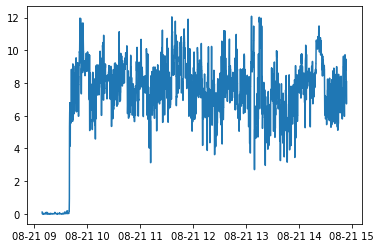

In [16]:
plt.plot(df.speed.rolling('20s').min())

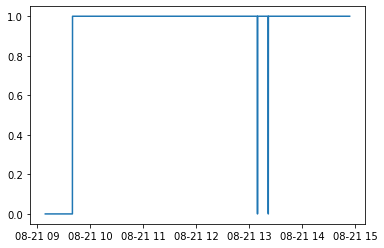

In [17]:
plt.plot(df.speed.rolling('10s').min() > 3)

In [18]:
(df.speed.rolling('10s').min() > 3).idxmax()

Timestamp('2021-08-21 09:39:41')

<AxesSubplot:>

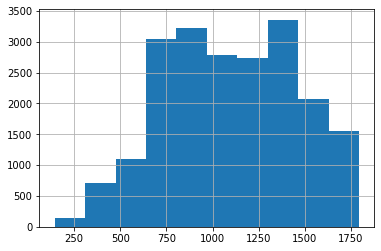

In [19]:
df.altitude.hist()

In [20]:
df.latitude.min(), df.latitude.max()

(60.5863662, 60.693849799999995)

In [21]:
df.longitude.min(), df.longitude.max()

(6.3400115, 6.4564122)

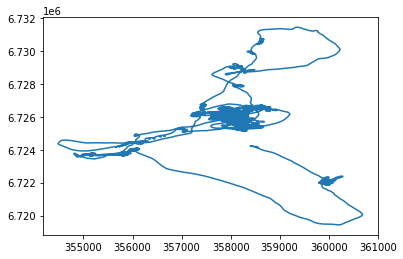

In [22]:
plt.plot(df.x, df.y)

<AxesSubplot:xlabel='pressure'>

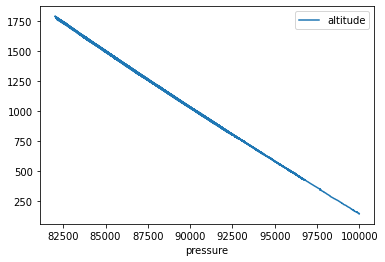

In [23]:
df.plot(x='pressure', y='altitude')
# mask.plot(x='pressure', y='altitude')

<AxesSubplot:>

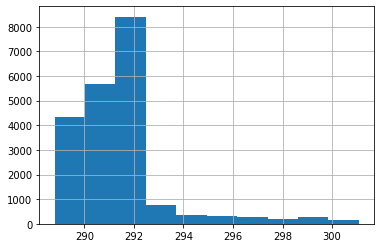

In [24]:
df.theta.hist()
# mask.theta.hist()

<AxesSubplot:>

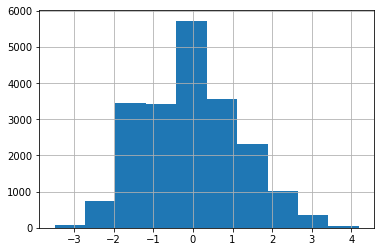

In [25]:
df.vario.hist()

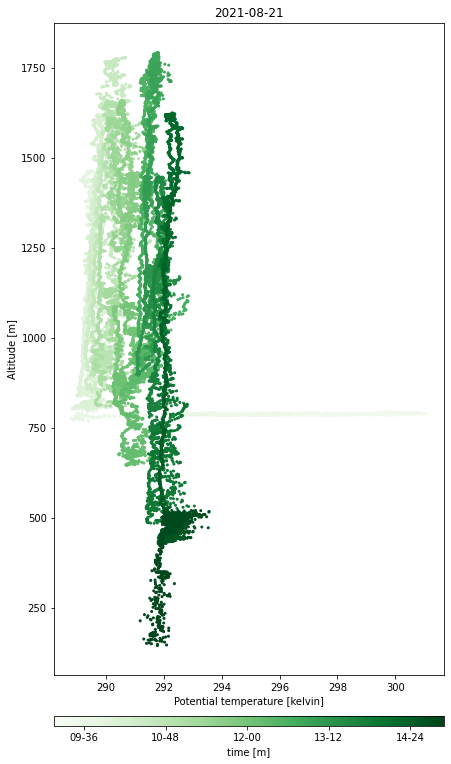

In [26]:
import matplotlib.dates as mdates

plt.figure(figsize=(7,15))
# plt.scatter(df['theta'], df['altitude'], c=df.vario, cmap='coolwarm')

plt.scatter(df['theta'], df['altitude'], c=mdates.date2num(df.time.dt.to_pydatetime()), cmap='Greens', s=4)

plt.gcf().patch.set_facecolor('xkcd:white')
plt.xlabel('Potential temperature [kelvin]')
plt.ylabel('Altitude [m]')

clb = plt.colorbar(label='time [m]', orientation='horizontal', 
                   aspect=40, pad=0.05, format=mdates.DateFormatter('%H-%M')
)

# clb.update_ticks()

plt.title('{}'.format(df.iloc[0].time.date()))


plt.savefig(fname=f'art-{df.time.iloc[0].date()}.png', dpi=200, bbox_inches='tight')



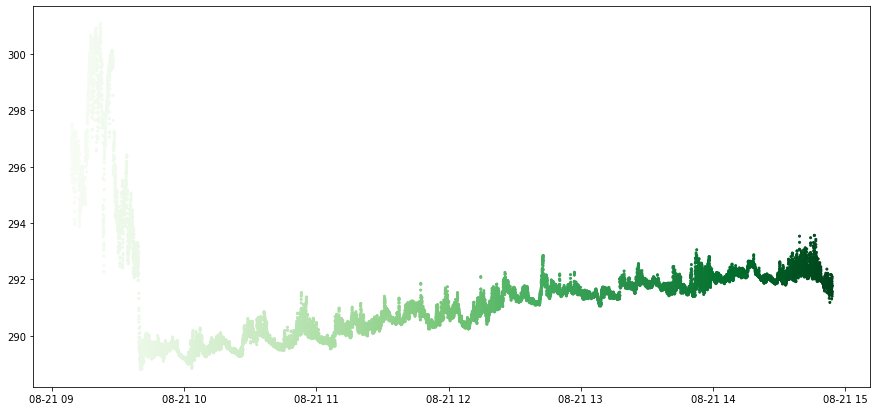

In [27]:
plt.figure(figsize=(15,7))
plt.scatter(df.time, df['theta'], c=df.time, cmap='Greens', s=4)

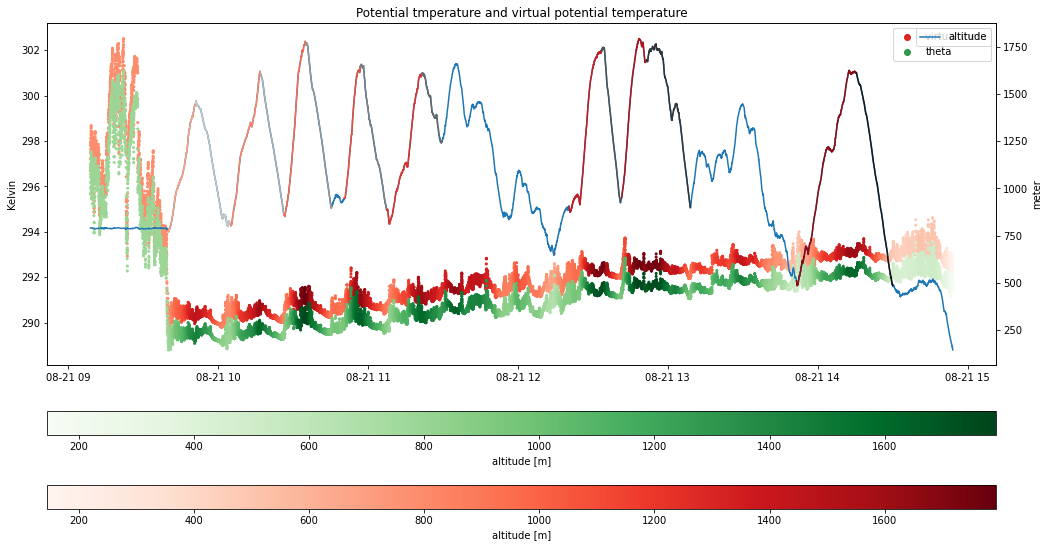

In [28]:

thermals = [
    ('2021-08-21 9:40:00', '2021-08-21 9:51:00', '2021-08-21 10:05:00'),
    ('2021-08-21 10:05:00', '2021-08-21 10:17:00', '2021-08-21 10:26:30'),
    ('2021-08-21 10:26:30', '2021-08-21 10:35:00', '2021-08-21 10:45:30'),
    ('2021-08-21 10:50:30', '2021-08-21 10:57:00', '2021-08-21 11:07:30'),
    ('2021-08-21 11:07:30', '2021-08-21 11:21:30', '2021-08-21 11:29:30'),
    ('2021-08-21 12:20:30', '2021-08-21 12:33:30', '2021-08-21 12:41:00'),
    ('2021-08-21 12:41:30', '2021-08-21 12:51:30', '2021-08-21 13:09:00'),
    ('2021-08-21 13:51:30', '2021-08-21 14:15:30', '2021-08-21 14:30:00'),
]

plt.figure(figsize=(17,10))
plt.gcf().patch.set_facecolor('xkcd:white')

plt.title('Potential tmperature and virtual potential temperature')
plt.scatter(df.time, df.theta_virtual, c=df.altitude, cmap='Reds', s=4, label='virtual theta')
plt.colorbar(label='altitude [m]', orientation='horizontal', aspect=40, pad=0.01)

plt.scatter(df.time, df['theta'], c=df.altitude, cmap='Greens', s=4, label='theta')
plt.colorbar(label='altitude [m]', orientation='horizontal', aspect=40, pad=0.1)

ax = plt.gca()
plt.ylabel('Kelvin')

plt.legend(markerscale=3, scatterpoints=1)
legend = ax.get_legend()
legend.legendHandles[0].set_color(plt.cm.Reds(.7))
legend.legendHandles[1].set_color(plt.cm.Greens(.7))

ax2 = ax.twinx()
ax2.plot(df.time, df.altitude, label='altitude')

for i, thm in enumerate(thermals):
    
    offset = 4
    x = (offset+i) / (len(thermals) + offset)
    
    c_up = plt.get_cmap('Reds')(x)
    c_down = plt.get_cmap('Greys')(x)

    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])

    ax2.plot(up.time, up.altitude, c=c_up)
    ax2.plot(dw.time, dw.altitude, c=c_down)

plt.legend()

plt.ylabel('meter')
plt.xlabel('time UTC')
plt.show()

In [29]:
data_frames = []

label = np.random.randint(0x7FFFFFFF)
for i, thm in enumerate(thermals):
    t = pd.DataFrame(select(df, thm[0], thm[2]))
    t['labels'] = label + i
    data_frames += [t]

data = pd.concat(data_frames)
data

time     id          dd               tt  \
time                                                                          
2021-08-21 09:40:00 2021-08-21 09:40:00  44507  2021/08/21  21:43:50.880341   
2021-08-21 09:40:01 2021-08-21 09:40:01  44507  2021/08/21  21:43:50.905767   
2021-08-21 09:40:02 2021-08-21 09:40:02  44507  2021/08/21  21:43:50.931667   
2021-08-21 09:40:03 2021-08-21 09:40:03  44507  2021/08/21  21:43:50.957692   
2021-08-21 09:40:04 2021-08-21 09:40:04  44507  2021/08/21  21:43:50.983809   
...                                 ...    ...         ...              ...   
2021-08-21 14:29:56 2021-08-21 14:29:56  44507  2021/08/21  21:51:22.214934   
2021-08-21 14:29:57 2021-08-21 14:29:57  44507  2021/08/21  21:51:22.240877   
2021-08-21 14:29:58 2021-08-21 14:29:58  44507  2021/08/21  21:51:22.266796   
2021-08-21 14:29:59 2021-08-21 14:29:59  44507  2021/08/21  21:51:22.292732   
2021-08-21 14:30:00 2021-08-21 14:30:00  44507  2021/08/21  21:51:22.318684   

                    code  pressure  temperature    RH  RH_temp  longitude  \
time                                                                        
2021-08-21 09:40:00   XQ   92835.0         9.94  61.4    12.28   6.409808   
2021-08-21 09:40:01   XQ   92828.0         9.84  62.0    12.15   6.409854   
2021-08-21 09:40:02   XQ   92861.0        10.18  62.9    12.15   6.409890   
2021-08-21 09:40:03   XQ   92886.0        10.02  63.6    12.02   6.409895   
2021-08-21 09:40:04   XQ   92864.0        10.00  64.6    11.97   6.409883   
...                  ...       ...          ...   ...      ...        ...   
2021-08-21 14:29:56   XQ   96088.0        15.55  43.7    16.35   6.446654   
2021-08-21 14:29:57   XQ   96111.0        15.58  43.6    16.35   6.446590   
2021-08-21 14:29:58   XQ   96123.0        15.59  43.3    16.35   6.446532   
2021-08-21 14:29:59   XQ   96129.0        15.63  43.3    16.37   6.446472   
2021-08-21 14:30:00   XQ   96130.0        15.70  43.4    16.39   6.446416   

                     ...         vy      speed        dx        dy    course  \
time                 ...                                                       
2021-08-21 09:40:00  ... -10.117893  10.337474  0.565996 -8.893654 -1.507242   
2021-08-21 09:40:01  ... -11.631903  11.727682  0.362036 -9.108176 -1.531069   
2021-08-21 09:40:02  ... -11.309704  11.311015  0.039770 -9.213177 -1.566480   
2021-08-21 09:40:03  ...  -9.981975  10.036531 -0.380060 -9.179018 -1.612178   
2021-08-21 09:40:04  ...  -8.281298   8.367356 -0.862711 -9.019494 -1.666156   
...                  ...        ...        ...       ...       ...       ...   
2021-08-21 14:29:56  ...   7.538703   8.193622 -2.811135  6.930117  1.956156   
2021-08-21 14:29:57  ...   7.973143   8.488763 -2.831229  6.905600  1.959885   
2021-08-21 14:29:58  ...   7.362158   7.938675 -2.850378  6.850674  1.965081   
2021-08-21 14:29:59  ...   6.442527   7.036836 -2.862461  6.760120  1.971339   
2021-08-21 14:30:00  ...   5.932581   6.605634 -2.869778  6.642088  1.978631   

                           dc  turning    wind_x    wind_y      labels  
time                                                                    
2021-08-21 09:40:00 -0.017867    False  0.896024 -3.455756  1207612819  
2021-08-21 09:40:01 -0.029619    False  0.908578 -3.404035  1207612819  
2021-08-21 09:40:02 -0.040555    False  0.916081 -3.329879  1207612819  
2021-08-21 09:40:03 -0.049838    False  0.940167 -3.331787  1207612819  
2021-08-21 09:40:04 -0.056737    False  0.897977 -3.445464  1207612819  
...                       ...      ...       ...       ...         ...  
2021-08-21 14:29:56  0.002788    False -2.911838  7.477287  1207612826  
2021-08-21 14:29:57  0.004463    False -2.783998  7.477509  1207612826  
2021-08-21 14:29:58  0.005727    False -2.779703  7.471498  1207612826  
2021-08-21 14:29:59  0.006775    False -2.783972  7.451623  1207612826  
2021-08-21 14:30:00  0.008067    False -2.785055  7.458503  1207612826  

[11468 rows x 




# Wind section

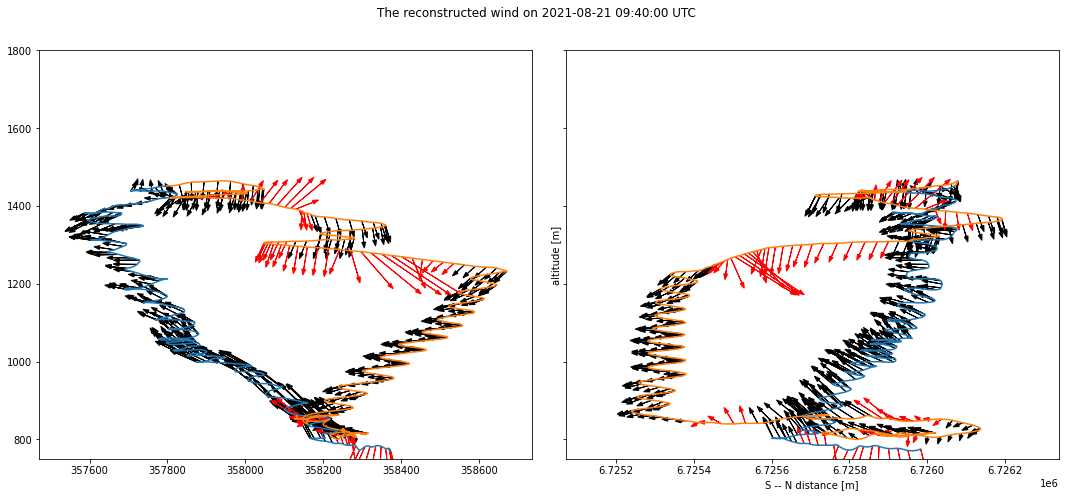

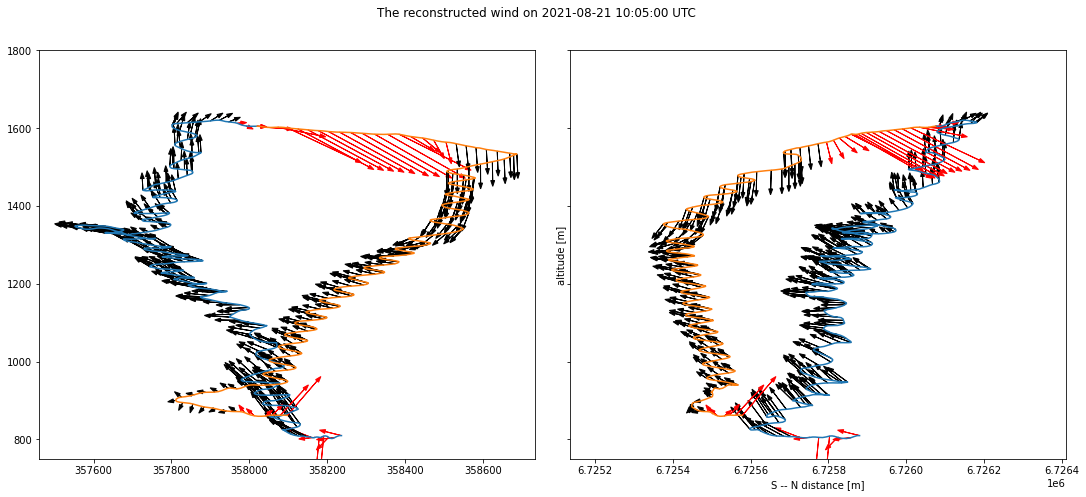

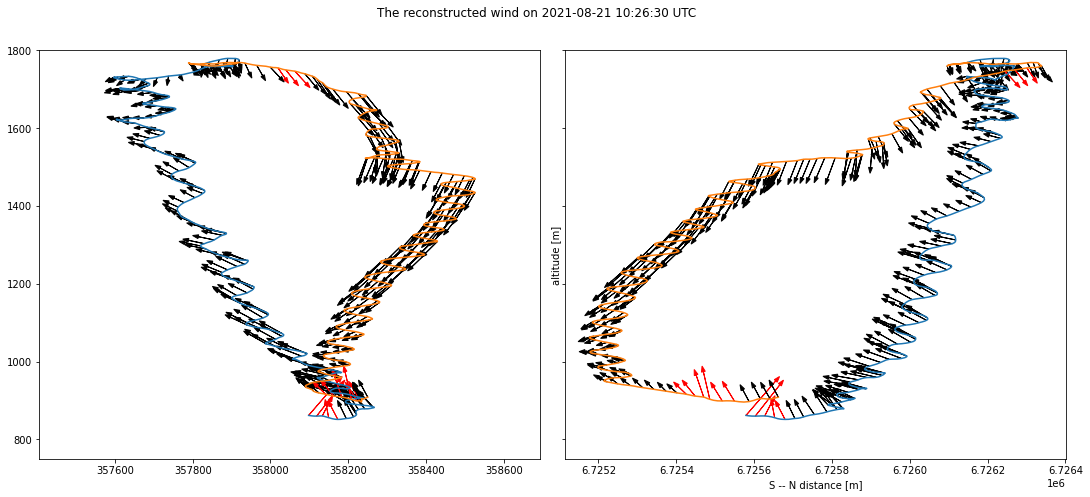

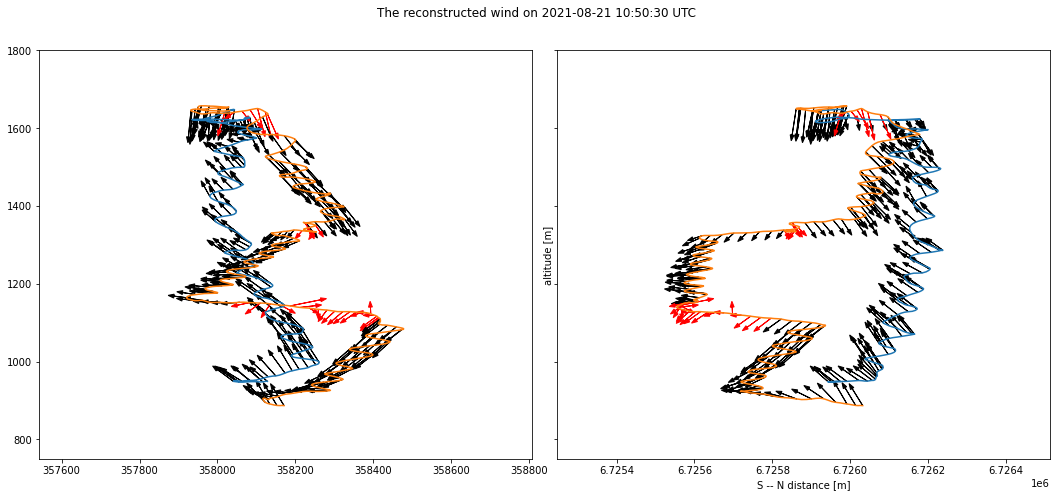

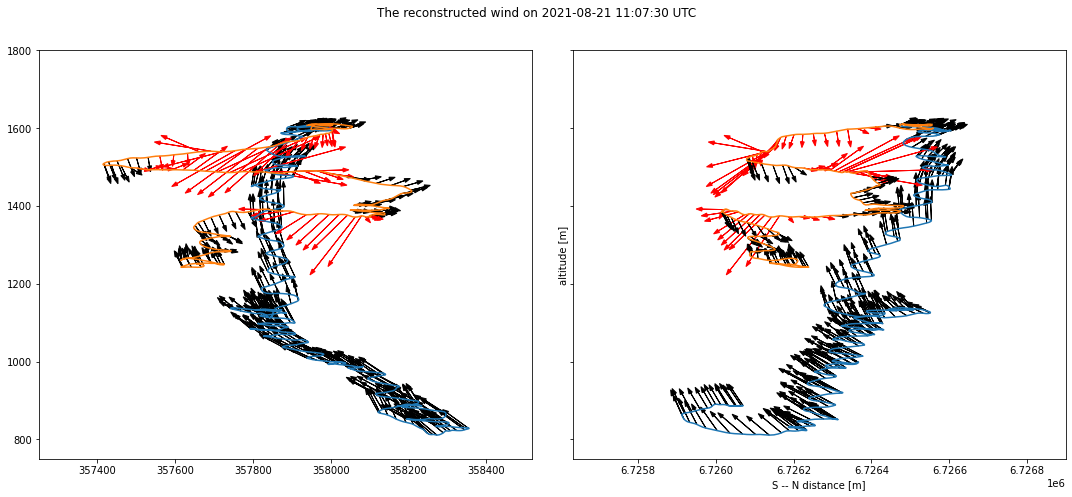

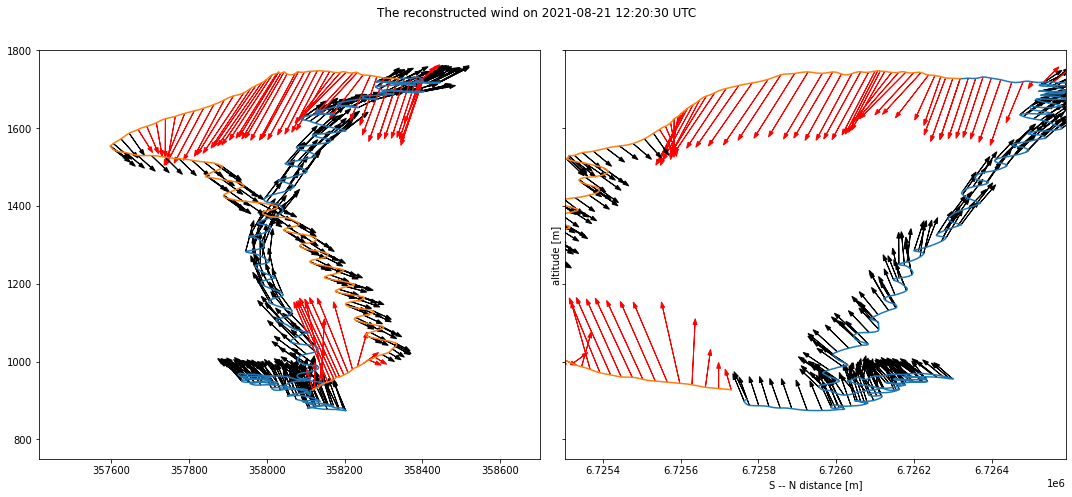

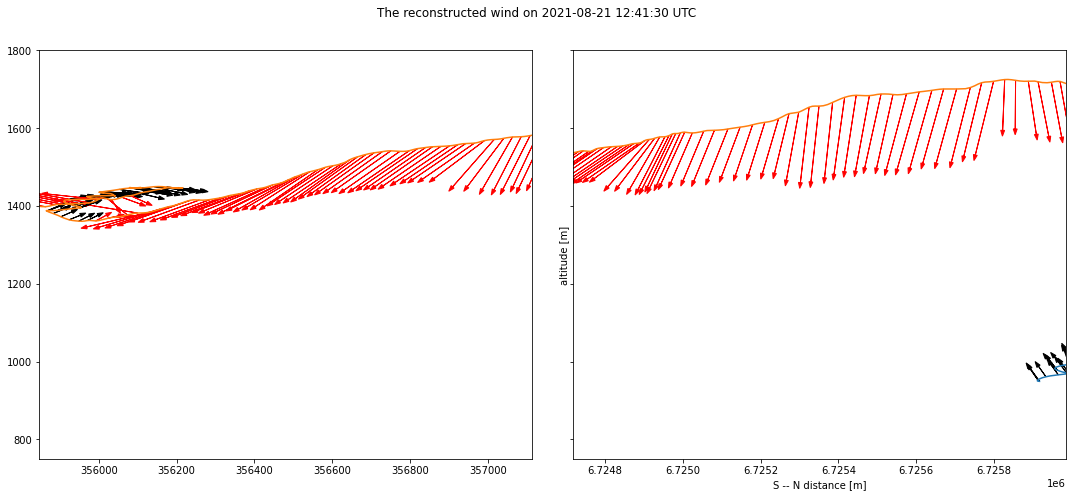

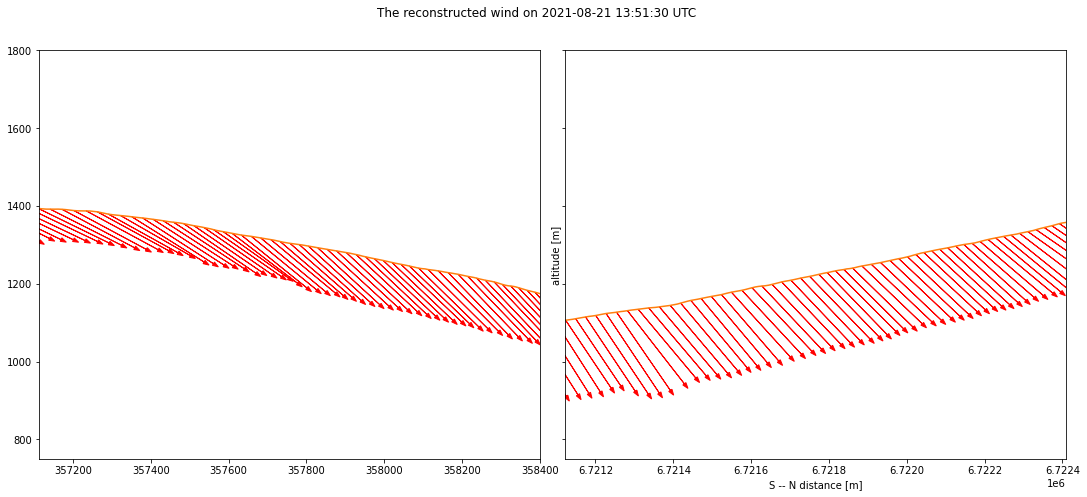

In [141]:
def plot_wind_arrows(x, y, df, k=20, head_width=10.0, plt=plt):

    a = df.iloc[::3]
    aspect = get_aspect(plt)

    for index, e in a.iterrows():    
        plt.arrow(e[x], e[y], k * aspect * e.wind_x, k *  e.wind_y, head_width=head_width, color=( 'black' if e.turning else 'red'))

def plot_wind_thermal(df, thm):
    
    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])

    fig, ax = plt.subplots(figsize=(15,7), nrows=1, ncols=2, sharey=True, sharex=False, )
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(f'The reconstructed wind on {up.time.iloc[0]} UTC\n')
      
    # Left plot
    #
#     ax1 = plt.subplot(1,2,1)
#     plt.gca()

    ax[0].set(aspect=1, adjustable='datalim')
    ax[1].set(aspect=1, adjustable='datalim')
    ax[0].set_ylim(750,1800)
    
    ax[0].plot(up.x, up.altitude)
    ax[0].plot(dw.x, dw.altitude)

    plot_wind_arrows('x', 'altitude', up, plt=ax[0])
    plot_wind_arrows('x', 'altitude', dw, plt=ax[0])
    
    plt.ylabel('altitude [m]')
    plt.xlabel('W -- E distance [m]')
    

    
    # Right plot
    #
#     plt.subplot(1,2,2, sharey=ax1)

    plt.plot(up.y, up.altitude)
    plt.plot(dw.y, dw.altitude)
    plot_wind_arrows('y', 'altitude', up, plt=ax[1])
    plot_wind_arrows('y', 'altitude', dw, plt=ax[1])
    
    plt.xlabel('S -- N distance [m]')
    plt.tight_layout()
    plt.show()

# thm =  thermals[0]

for thm in thermals:
    plot_wind_thermal(df, thm)




# Here I try the triptych with wind arrows 

In [144]:
def plot_down_up_down(up, dw, dw2, temp='temperature', humid='dewpoint', c=('darkred', 'black', 'gray'), sigma = 5):
    
    c_up, c_down, c_down_2 = c
    
    
    fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,10))
    fig.patch.set_facecolor('xkcd:white')

    ax[0].plot(up.vario, up.altitude, c=c_up,   label='up {}'.format(up.time.iloc[0].time()))
    ax[0].plot(dw.vario, dw.altitude, c=c_down, label='down {}'.format(dw.time.iloc[0].time()))
    ax[0].plot(dw2.vario, dw2.altitude, c=c_down_2, label='down {}'.format(dw2.time.iloc[0].time()))

    ax[0].set_title('Vertical velocity\naverage climb: {:0.2f} m/s, average sink: {:0.2f}'
                    .format(up.vario.mean(), dw.vario.mean()))
    ax[0].set_xlabel('[m/s]')
    ax[0].legend(loc=1)

    ax[1].plot(gaussian_filter1d(up[temp].values, sigma, mode='nearest'), 
               up.altitude, c=c_up, label='thermal up {}'.format(up.time.iloc[0].time()),)
    ax[1].plot(gaussian_filter1d(dw[temp].values, sigma, mode='nearest'), 
               dw.altitude, c=c_down, label='spiral down {}'.format(dw.time.iloc[0].time()),)
    ax[1].plot(gaussian_filter1d(dw2[temp].values, sigma, mode='nearest'), 
               dw2.altitude, c=c_down_2, label='spiral down {}'.format(dw.time.iloc[0].time()),)

    if humid is not None:
        ax[1].plot(up[humid].values, up.altitude, ':', c=c_up)
        ax[1].plot(dw[humid].values, dw.altitude, ':', c=c_down)
        ax[1].plot(dw2[humid].values, dw2.altitude, ':', c=c_down_2)
        
    ax[2].plot(up.x, up.altitude, ':', c='gray', linewidth=1)
    plot_wind_arrows('x', 'altitude', up.iloc[::3], k=10, head_width=10.0, plt=ax[2])
    plot_wind_arrows('x', 'altitude', dw.iloc[::3], k=10, head_width=10.0, plt=ax[2])
            
    ax[0].set_ylabel('Altitude [m]')
    ax[1].set_title('{}s Average {}'.format( sigma, temp ))
    ax[2].set_title('Wind')

    plt.suptitle('Glider Flight Analysis, {} {} -- {}'.format(up.time.iloc[0].date(), up.time.iloc[0].time(), dw.time.iloc[-1].time()))
    plt.tight_layout()
    plt.savefig('../data/iMet/export/img/triptych-wind-{} {}.png'.format(up.time.iloc[0].date(), up.time.iloc[0].time().strftime('%H-%M')))
    plt.show()

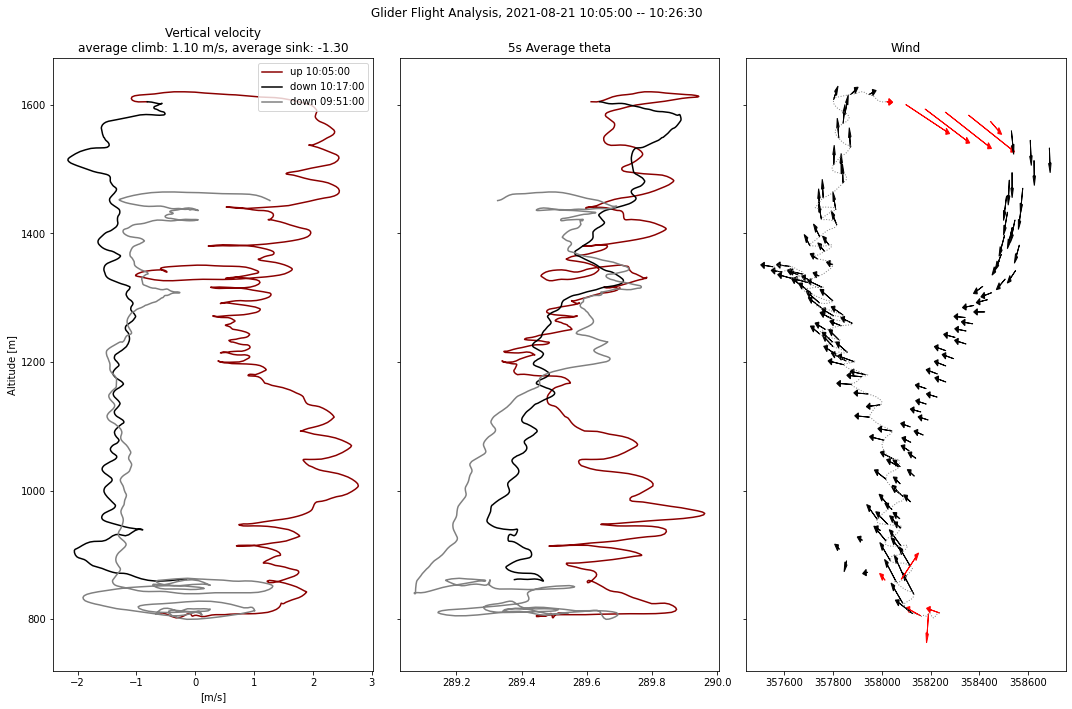

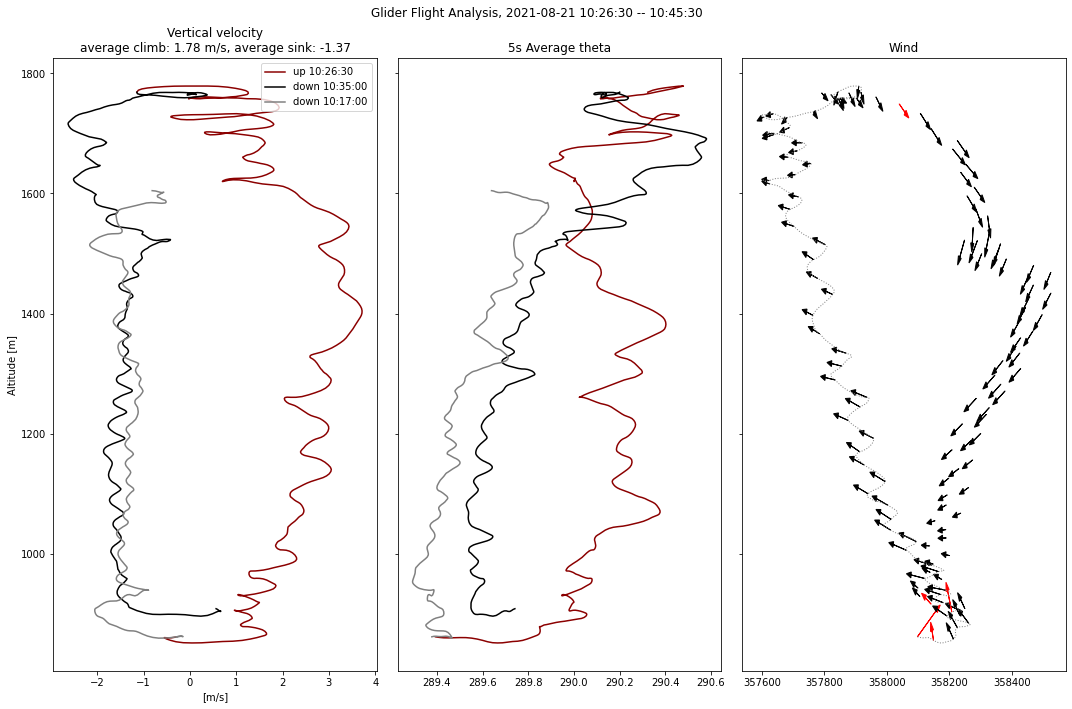

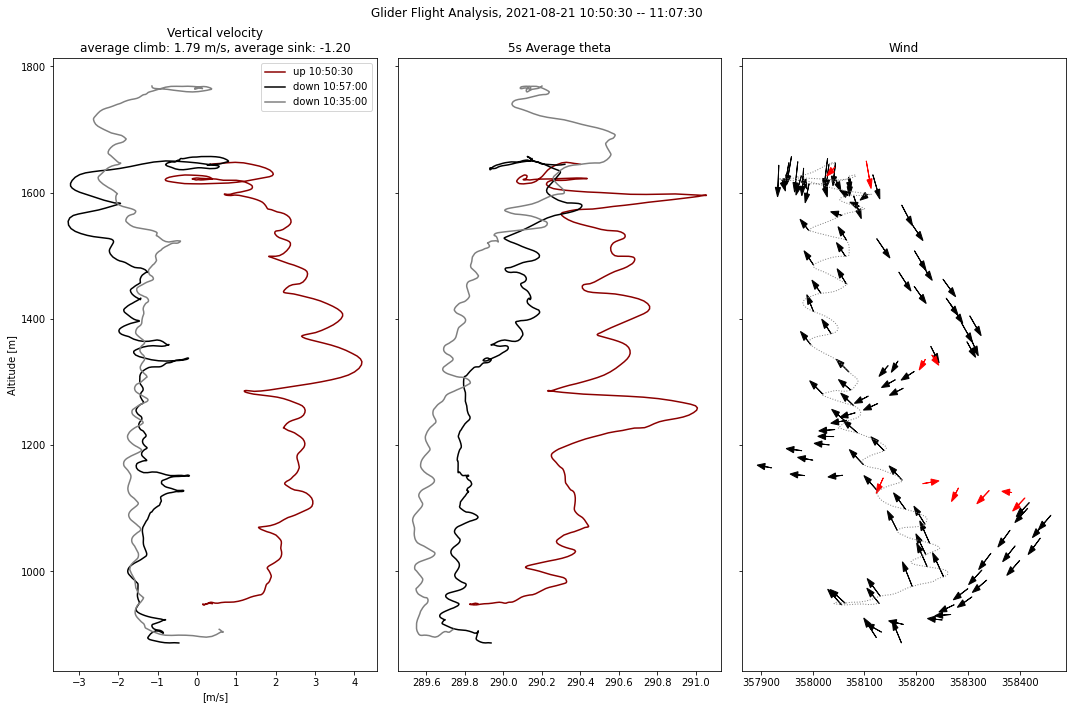

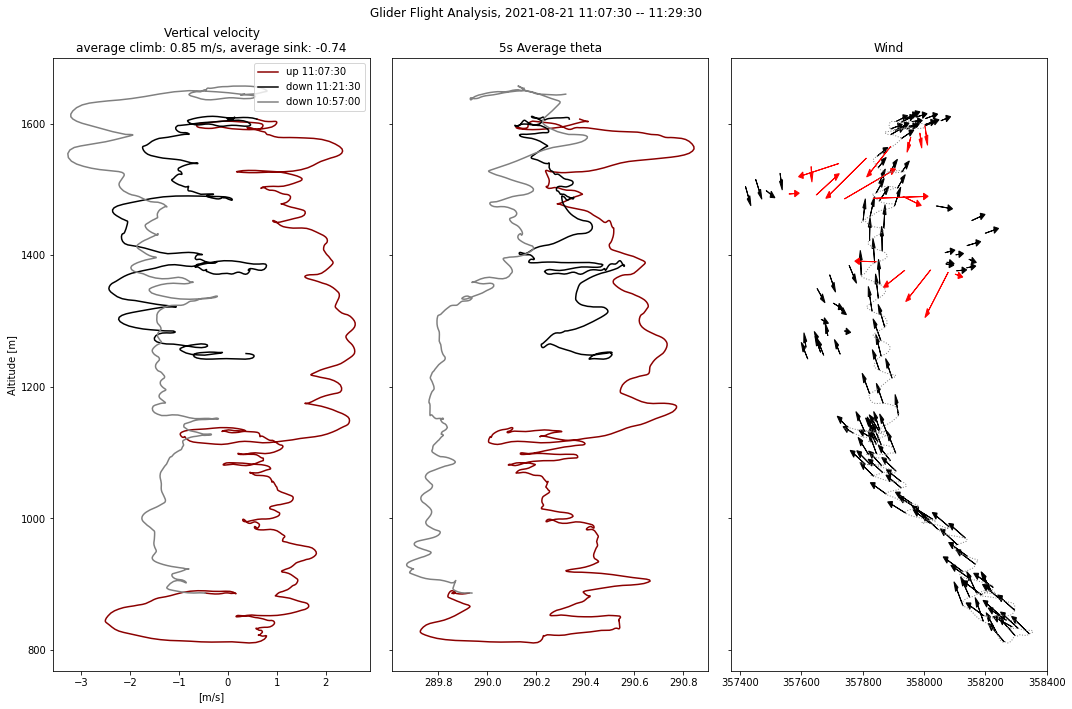

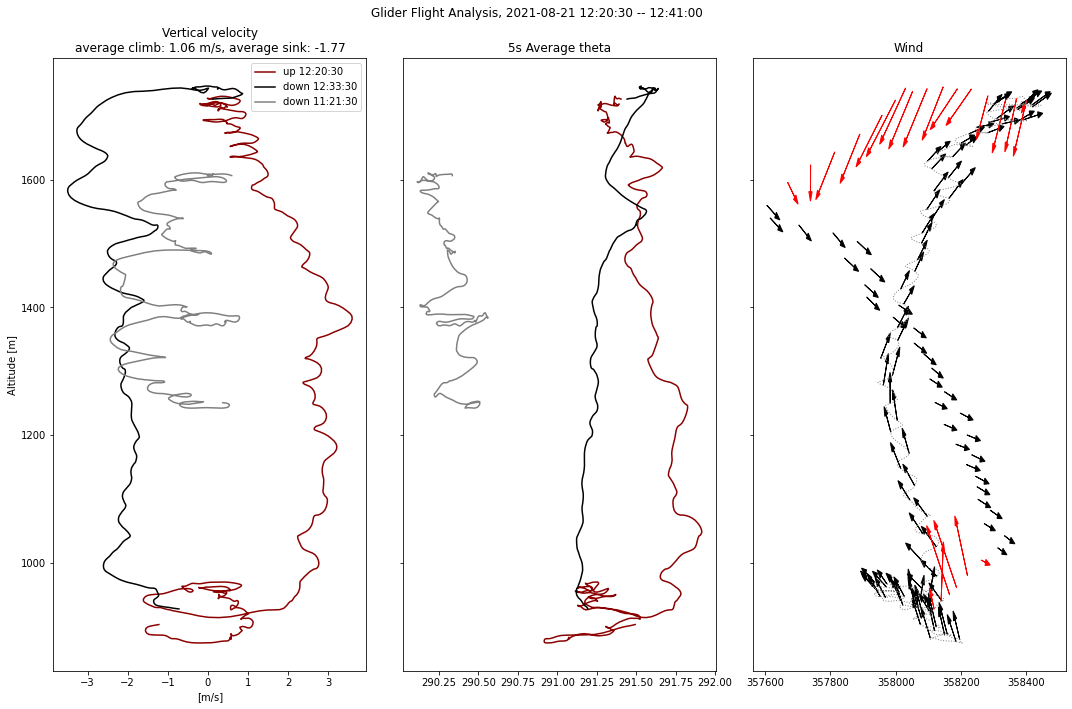

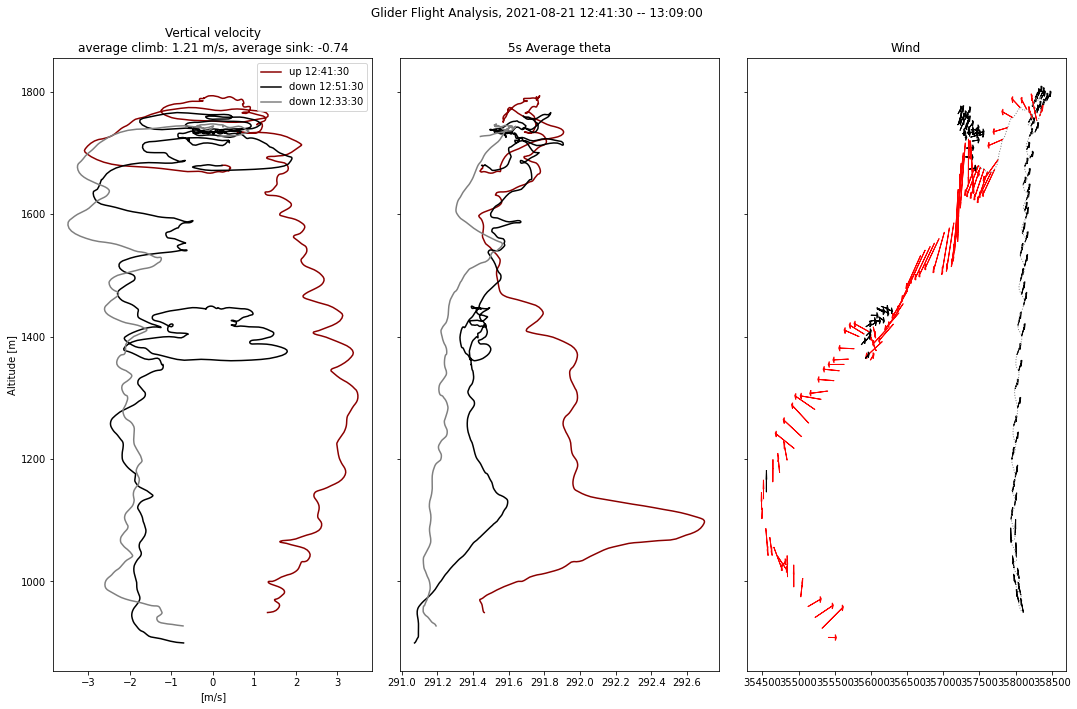

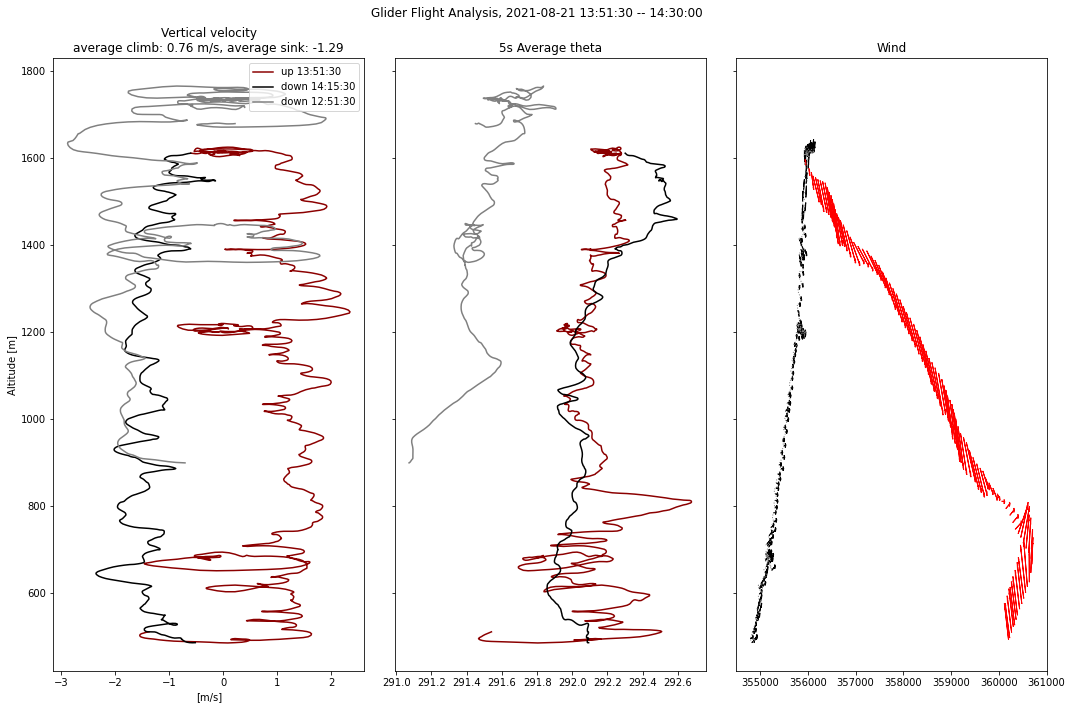

In [145]:

for i in range(1, len(thermals)):
    
    thm = thermals[i]
    t = thermals[i-1]

    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])
    dw2 = select(df, t[1], t[2])


    plot_down_up_down(up, dw, dw2, temp='theta', humid=None)

In [129]:

# https://stackoverflow.com/questions/41597177/get-aspect-ratio-of-axes


from operator import sub
def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

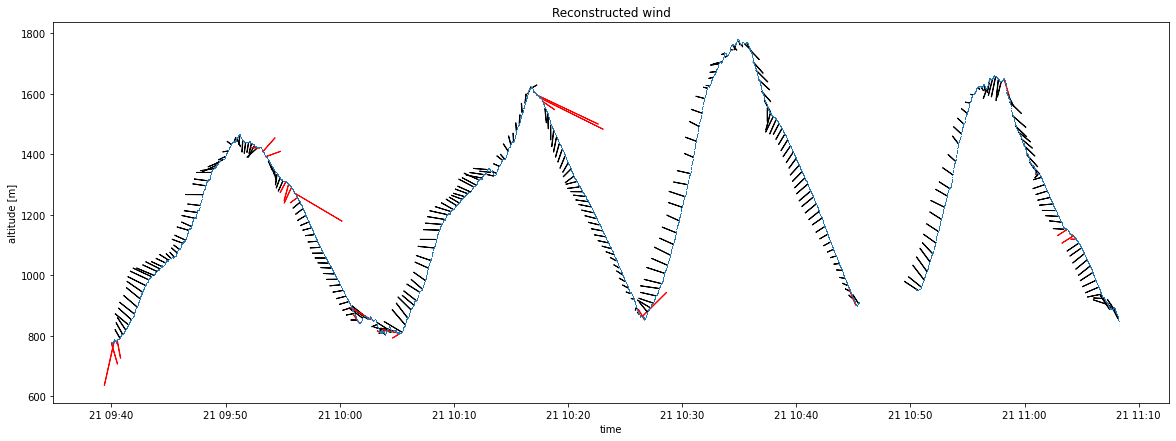

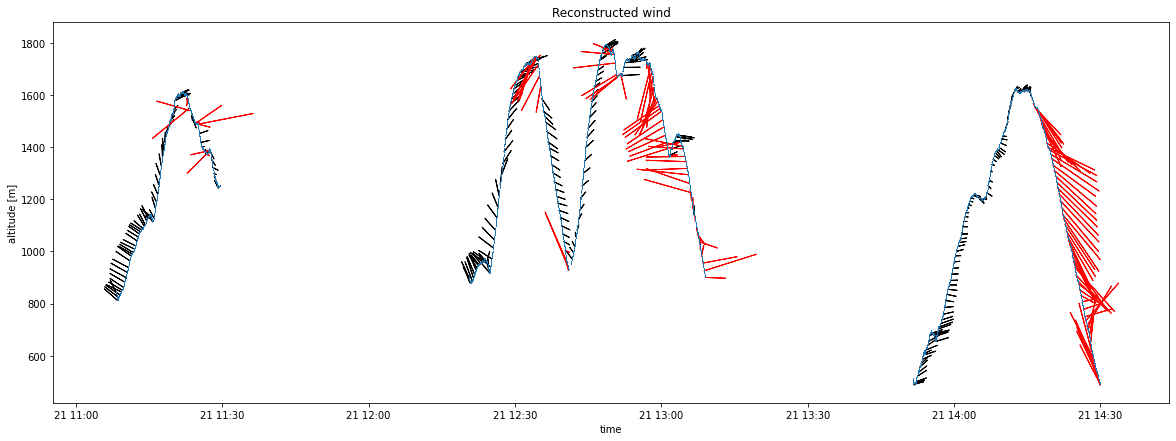

In [55]:
def plot_wind_arrows_over_time(x, y, df, k=20):
    plt.figure(figsize=(20,7))
    plt.title('Reconstructed wind')
    plt.xlabel('time')
    plt.ylabel('altitude [m]')
    a = df.iloc[::15]
    plt.plot(df.time, df.altitude, ',')
    aspect = get_aspect(plt.gca())
    for index, e in a.iterrows():    
#         plt.arrow(e[x], e[y], k * e.wind_x, k *  e.wind_y, head_width=10, color=( 'black' if e.turning else 'red'))
        plt.arrow(e[x], e[y], k * aspect * e.wind_x, k * e.wind_y , width=aspect, head_width=0.0, color=( 'black' if e.turning else 'red'))
        
plot_wind_arrows_over_time('time', 'altitude', data.iloc[:5000])
plt.show()

        
plot_wind_arrows_over_time('time', 'altitude', data.iloc[5000:])
plt.show()


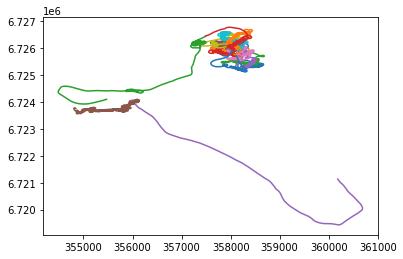

In [211]:
for thm in thermals:
    
    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])

    plt.plot(dw.x, dw.y)
    plt.plot(up.x, up.y)

In [212]:
def plot_up_down(up, dw, temp='theta', humid='dewpoint', c=('darkred', 'black'), sigma = 5):
    
    c_up, c_down = c
    
    fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,10))
    fig.patch.set_facecolor('xkcd:white')

    ax[0].plot(up.vario, up.altitude, c=c_up,   label='up {}'.format(up.time.iloc[0].time()))
    ax[0].plot(dw.vario, dw.altitude, c=c_down, label='down {}'.format(dw.time.iloc[0].time()))

    ax[0].set_title('Vertical velocity\naverage climb: {:0.2f} m/s, average sink: {:0.2f}'
                    .format(up.vario.mean(), dw.vario.mean()))
    ax[0].set_xlabel('[m/s]')
    ax[0].legend(loc=1)

    ax[1].plot(gaussian_filter1d(up[temp].values, sigma, mode='nearest'), 
               up.altitude, c=c_up, label='thermal up {}'.format(up.time.iloc[0].time()),)
    ax[1].plot(gaussian_filter1d(dw[temp].values, sigma, mode='nearest'), 
               dw.altitude, c=c_down, label='spiral down {}'.format(dw.time.iloc[0].time()),)

#     ax[1].plot(sel.theta.mean() * np.ones_like(sel.altitude.values), sel.altitude)
#     ax[1].set_xlabel('theta [kelvin]')

    ax[2].plot(up[humid], up.altitude, c=c_up)
    ax[2].plot(dw[humid], dw.altitude, c=c_down)
    
    ax[0].set_ylabel('Altitude [m]')
    ax[1].set_title('{}s Average {}'.format( sigma, temp ))
    ax[2].set_title(humid)

    plt.suptitle('Glider Flight Analysis, {} {} -- {}'.format(up.time.iloc[0].date(), up.time.iloc[0].time(), dw.time.iloc[-1].time()))
    plt.tight_layout()
    plt.savefig('../data/iMet/export/img/triptych-{} {}.png'.format(up.time.iloc[0].date(), up.time.iloc[0].time().strftime('%H-%M')))
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/iMet/export/img/triptych-2021-08-21 09-40.png'

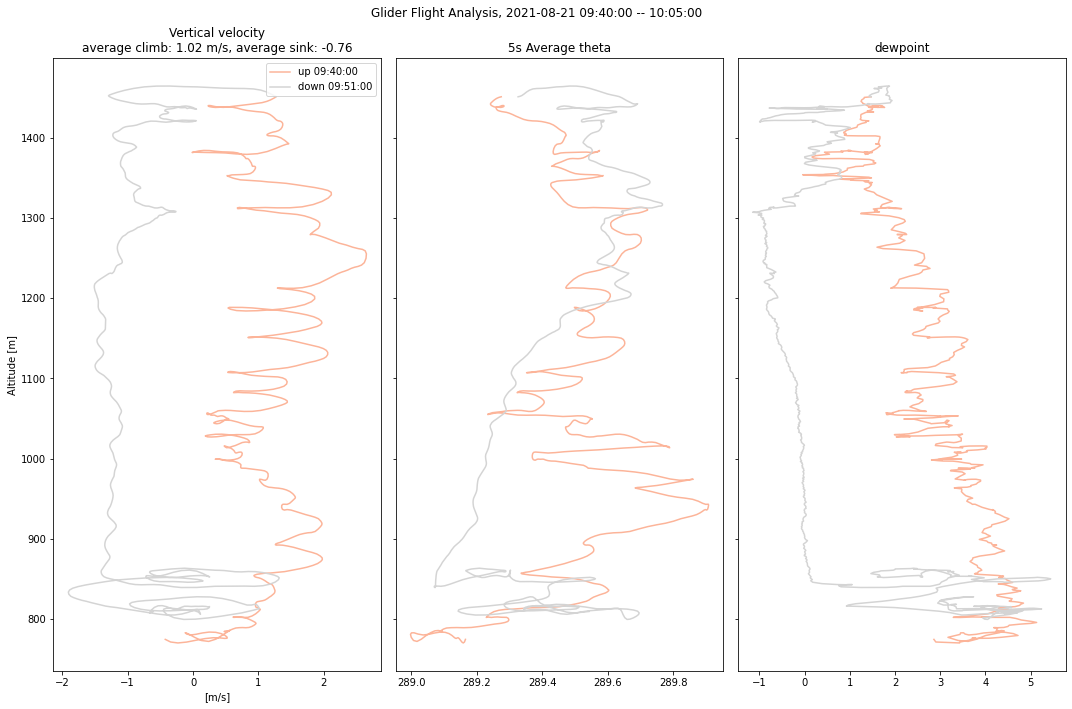

In [213]:
 
LR_map = c_up_down(linear_range(-3, len(thermals)))


for i, thm in enumerate(thermals):

    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])

    plot_up_down(up, dw, c=LR_map(i))

In [ ]:
temp='theta'
humid='dewpoint'
sigma=5

fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,10))
fig.patch.set_facecolor('xkcd:white')


for i, thm in enumerate(thermals):
        
#     c_up = plt.get_cmap('Reds')(LR(i))
#     c_down = plt.get_cmap('Greys')(LR(i))
    c_up, c_down = LR_map(i)
    
    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])
    
    ax[0].plot(up.vario, up.altitude, c=c_up,   label='up {}'.format(up.time.iloc[0].time()))
    ax[0].plot(dw.vario, dw.altitude, c=c_down, label='down {}'.format(dw.time.iloc[0].time()))

    ax[1].plot(gaussian_filter1d(up[temp].values, sigma, mode='nearest'), 
               up.altitude, c=c_up, label='thermal up {}'.format(up.time.iloc[0].time()),)
    ax[1].plot(gaussian_filter1d(dw[temp].values, sigma, mode='nearest'), 
               dw.altitude, c=c_down, label='spiral down {}'.format(dw.time.iloc[0].time()),)

#     ax[1].plot(sel.theta.mean() * np.ones_like(sel.altitude.values), sel.altitude)
#     ax[1].set_xlabel('theta [kelvin]')

    ax[2].plot(up[humid], up.altitude, c=c_up)
    ax[2].plot(dw[humid], dw.altitude, c=c_down)
    
    ax[0].set_ylabel('Altitude [m]')
    ax[1].set_title('{}s Average {}'.format( sigma, temp ))
    ax[2].set_title(humid)

ax[0].set_title('Vertical velocity')
ax[0].set_xlabel('[m/s]')
ax[0].legend()
    
plt.suptitle('Glider Flight Analysis, {} {} -- {}'.format(up.time.iloc[0].date(), up.time.iloc[0].time(), dw.time.iloc[-1].time()))
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(df.time, df.theta)
plt.plot(df.time, gaussian_filter1d(df.theta, 60))
plt.xlim(df.time.iloc[0] - pd.Timedelta('1s'), df.time.iloc[0] + pd.Timedelta('120s'))

d_theta = df.theta.values - gaussian_filter1d(df.theta.values, 60)

In [ ]:
plt.scatter(gaussian_filter1d(np.abs(d_theta), 10), 
            gaussian_filter1d(df.vario.values, 10), s=1)

In [ ]:
plt.plot(df.vx, df.vy, ',')

In [ ]:
def plot_variable_for_labels(data, variables, use_pressure=False, filter_y=False, sigma=5):

    fig = plt.figure(figsize=(14,10))
    
    if not isinstance(variables, type([])):
        variables = [variables]
    
    cmaps = ['Oranges', 'Greens']
    
    for i, variable in enumerate(variables):
        
        cmap = plt.get_cmap(cmaps[i])

        LR = linear_range(data.index[0], data.index[-1])

        y_var = 'altitude'
        y_label = 'altitude [m]'

        if use_pressure:
            y_var = 'pressure'
            y_label = 'pressure [Pa]'


        for l in data.label.unique():
        #     print(l)
            dl = data[data.label==l]

            y = dl[y_var]
            if filter_y:
                y = gaussian_filter1d(dl[y_var], sigma)

            plt.plot(gaussian_filter1d(dl[variable], sigma), 
                     y, 
                     label="{} {}".format(dl.index[0].time(), variable), 
                     c=cmap(LR(dl.index[0])))

    plt.title('Filtered ({} sec) {} during ascent on {}'.format(sigma, ', '.join(variables), data.index[0].date()))
    plt.ylabel(y_label)
    plt.xlabel(variables[0])
    plt.legend()
    
    if use_pressure:
        plt.gca().invert_yaxis()
        
    plt.gcf().patch.set_facecolor('xkcd:white')
    
    plt.savefig(file_name[:-4] + '_' + '_'.join(variables) + '.png')
    
        
        

# The sounding profile

The closest sounding station is at Sola airport.

In [ ]:
sounding = nc.Dataset('../data/Soundings/sola_20210731-20210831.nc')

sounding_day_idx = 41

plt.plot(sounding['air_temperature'][sounding_day_idx], sounding['altitude'][sounding_day_idx])
plt.ylim(0,2000)


In [ ]:
def get_sounding_day(sounding, index):
    return datetime.datetime.fromtimestamp(sounding['time'][index], tz=datetime.timezone.utc)

[ (i, get_sounding_day(sounding, i)) for i in range(sounding['time'].shape[0]) ]

In [ ]:
sounding.variables

In [41]:
sigma = 5 # second

plt.figure(figsize=(10,7))
cmap = plt.get_cmap('Oranges')
cmap2 = plt.get_cmap('Greys')

LR = linear_range(df.index[0], df.index[-1])


for i, thm in enumerate(thermals):
    
    x = (offset+i) / (len(thermals) + offset)
    
    c_up = plt.get_cmap('Reds')(x)
    c_down = plt.get_cmap('Greys')(x)
    
    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])
    
    plt.plot(gaussian_filter1d(up.temperature, sigma), up.pressure, label=up.index[0], c=cmap(LR(up.index[0])))
    plt.plot(gaussian_filter1d(dw.temperature, sigma), dw.pressure, label=dw.index[0], c=cmap2(LR(up.index[0])))
    
plt.plot(sounding['air_temperature'][sounding_day_idx] - 273.15, 
         sounding['air_pressure'][sounding_day_idx] * 100, 
         label='Sola sounding {}'.format(get_sounding_day(sounding, sounding_day_idx)))

plt.title('Filtered ({} sec) Temperature during ascent on {}'.format(sigma, up.index[0].date()))
plt.ylabel('pressure [m]')
plt.xlabel('temperature [Celzius]')
plt.legend()

plt.gca().invert_yaxis()
plt.ylim(100000, 80000)
plt.xlim(-5, 20)
plt.gcf().patch.set_facecolor('xkcd:white')
plt.savefig('sounding-{}.png'.format(get_sounding_day(sounding, sounding_day_idx).date()))
plt.show()

NameError: name 'linear_range' is not defined

<Figure size 720x504 with 0 Axes>

# Model data

The historical AROME model data from the same location

Well, check the time evolution of the model data and check the location variation. I.e. the flight is over time over space, so compare like with like ^^

In [42]:
data.time[0].date().year

2021

In [43]:
meps = nc.Dataset(
    'https://thredds.met.no/thredds/dodsC/meps25epsarchive/{0}/{1:02}/{2:02}/meps_det_2_5km_{0}{1:02}{2:02}T12Z.nc'.format(
        data.time[0].date().year,
        data.time[0].date().month,
        data.time[0].date().day
    ))

meps_6 = nc.Dataset(
    'https://thredds.met.no/thredds/dodsC/meps25epsarchive/{0}/{1:02}/{2:02}/meps_det_2_5km_{0}{1:02}{2:02}T06Z.nc'.format(
        data.time[0].date().year,
        data.time[0].date().month,
        data.time[0].date().day
    ))

datetime.datetime.fromtimestamp(int(meps['time'][0]), tz=datetime.timezone.utc), nc.num2date(meps['time'][0], units='seconds since 1970-1-1 0:0:0')

(datetime.datetime(2021, 8, 21, 12, 0, tzinfo=datetime.timezone.utc),
 cftime.DatetimeGregorian(2021, 8, 21, 12, 0, 0, 0, has_year_zero=False))

In [44]:
df.latitude.min(), df.latitude.max()

loc = ((meps['latitude'][:] > df.latitude.min()) & (meps['latitude'][:] < df.latitude.max())) & ((meps['longitude'][:] > df.longitude.min()) & (meps['longitude'][:] < df.longitude.max()))
x, y = np.where(loc)
x = np.unique(x)
y = np.unique(y)


In [48]:
meps['latitude'], meps['y']

(<class 'netCDF4._netCDF4.Variable'>
 float64 latitude(y, x)
     units: degree_north
     long_name: latitude
     standard_name: latitude
     _ChunkSizes: [1069  949]
 unlimited dimensions: 
 current shape = (1069, 949)
 filling off,
 <class 'netCDF4._netCDF4.Variable'>
 float32 y(y)
     long_name: y-coordinate in Cartesian system
     standard_name: projection_y_coordinate
     units: m
     _ChunkSizes: 1069
 unlimited dimensions: 
 current shape = (1069,)
 filling off)

In [87]:
lon = meps['longitude'][x, y]
lat = meps['latitude'][x, y]

In [88]:
dlon = lon - data.longitude.mean()
dlat = lat - data.latitude.mean(), 

idx = np.argmin(np.power(dlat,2) + np.power(dlon,2))

AROME_index = np.unravel_index(idx, lon.shape)
AROME_index

(2, 1)

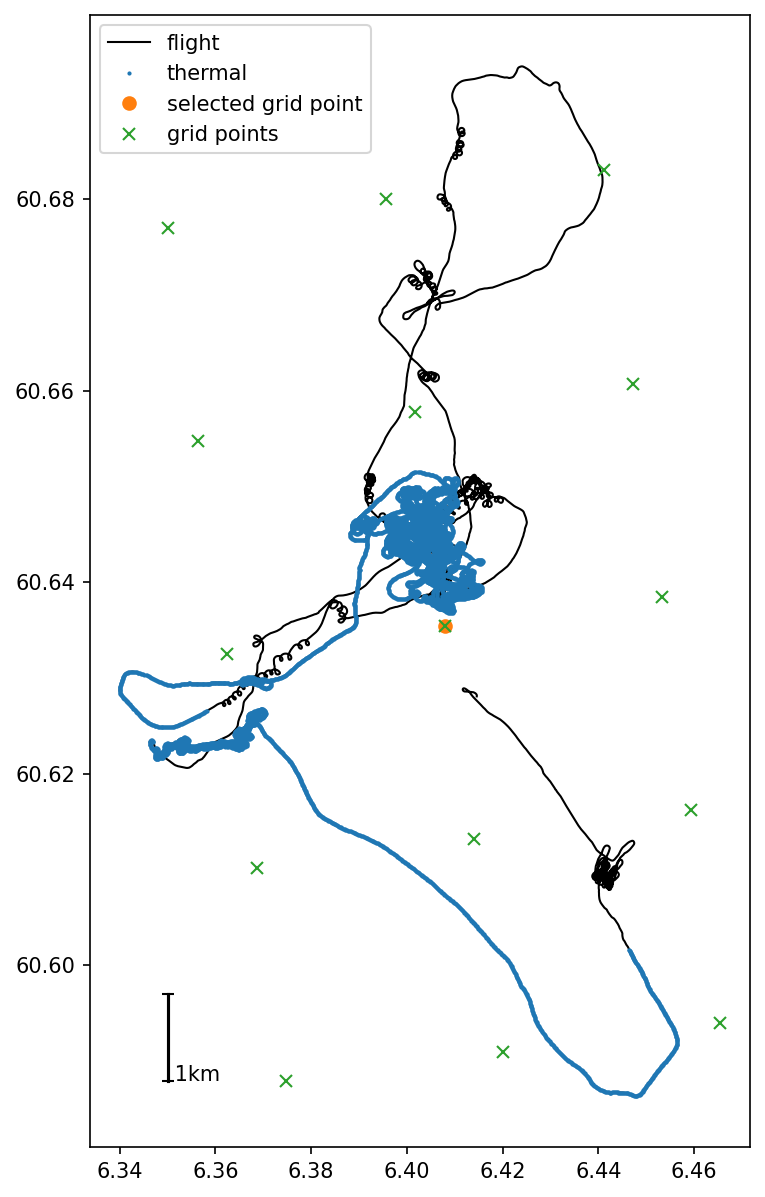

In [89]:
# AROME_index = (0, 2)

sel = data

plt.figure(figsize=(10,10), dpi=150)
plt.plot(df.longitude, df.latitude, 'k-', linewidth=1, label='flight')

plt.plot(sel.longitude, sel.latitude, '.', markersize=2, label='thermal')


x_corner = np.min(lon)
y_corner = np.min(lat)

# plt.plot([df.longitude.min(), df.longitude.min()], [df.latitude.min(), df.latitude.min() + 1/60/1.849], '_-k')
# plt.text(df.longitude.min(), df.latitude.min(), ' 1km' )

plt.plot([x_corner, x_corner], [y_corner, y_corner + 1/60/1.849], '_-k')
plt.text(x_corner, y_corner, ' 1km' )

plt.plot(lon[AROME_index], lat[AROME_index], 'o', label='selected grid point')
plt.plot(lon.flatten(), lat.flatten(), 'x', label='grid points')
plt.gca().set_aspect(2)
plt.legend()
plt.gcf().patch.set_facecolor('xkcd:white')

plt.show()

In [90]:
x.shape, y.shape

((5,), (3,))

In [91]:
AROME_index

(2, 1)

In [92]:
def get_AROME_at_index(meps, AROME_index, t = 0):

    print(AROME_index)

    T = meps['air_temperature_ml'][t, :, x[AROME_index[0]], y[AROME_index[1]]]
    p = np.outer(meps['hybrid'], (meps['surface_air_pressure'][t, 0, x[AROME_index[0]], y[AROME_index[1]]]))

    T.shape = p.shape
    theta = mpcalc.potential_temperature(p * units.pascal, np.array(T) * units.kelvin)
    w = meps['upward_air_velocity_ml'][t, :,x[AROME_index[0]], y[AROME_index[1]]]
    
    return T, p, theta


(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)


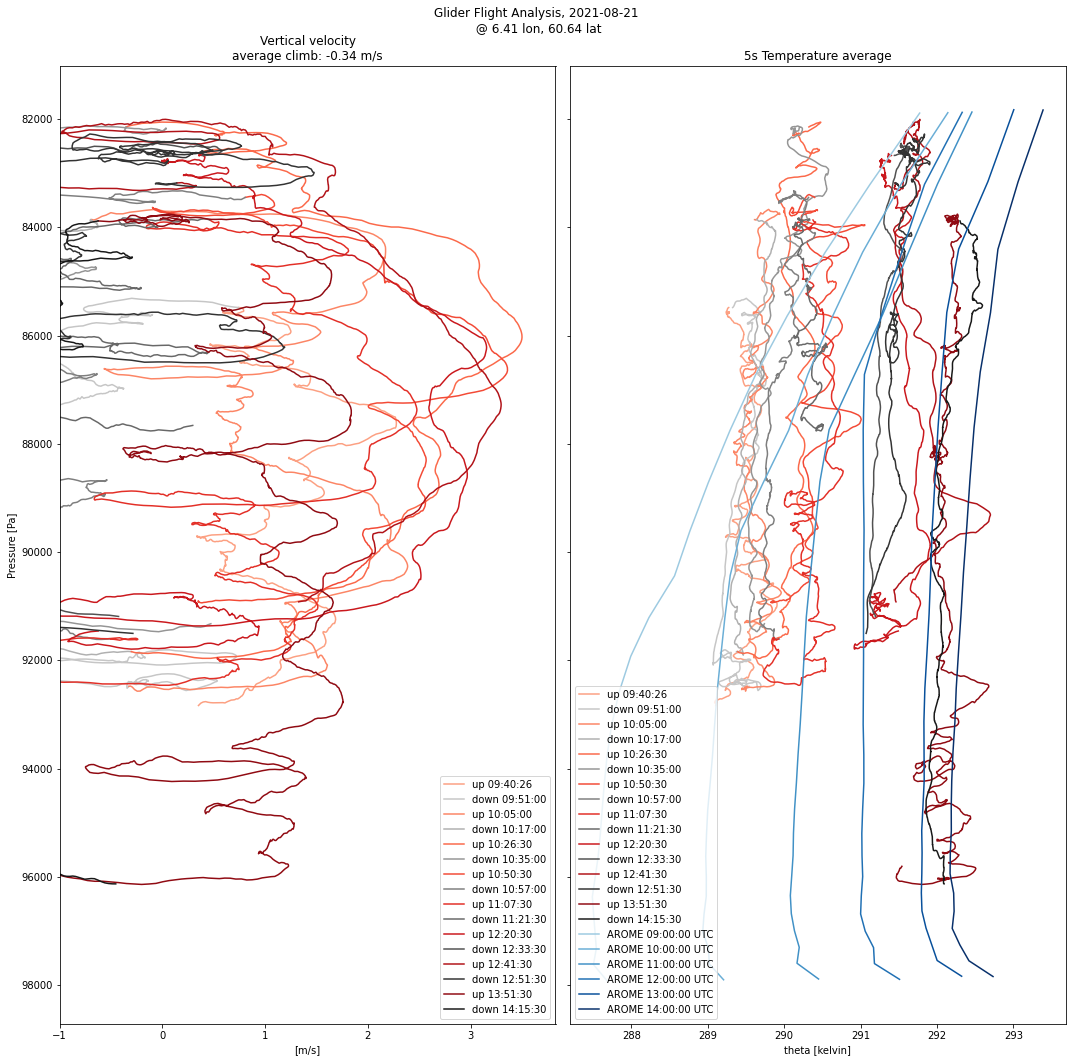

In [93]:

AROME_indices=[
    AROME_index,
#     (AROME_index[0] - 1, AROME_index[1] - 1),
#     (0,0)
]

sigma = 5

i=sel.altitude.argmin()
j=sel.altitude.argmax()

m = sel.iloc[[i,j]]
A = m.altitude.values
T = m.time.values.astype(float) * 1e-9

average_climb = (A[1] - A[0]) / (T[1] - T[0])

# plt.figure(figsize=(10,10),)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,15))


for i, thm in enumerate(thermals):
    
    x_val = (offset+i) / (len(thermals) + offset)
    
    c_up = plt.get_cmap('Reds')(x_val)
    c_down = plt.get_cmap('Greys')(x_val)
    
    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])
    
    ax[0].plot(up.vario, up.pressure, c=c_up,   label='up {}'.format(up.time.iloc[0].time()))
    ax[0].plot(dw.vario, dw.pressure, c=c_down, label='down {}'.format(dw.time.iloc[0].time()))

    ax[1].plot(gaussian_filter1d(up['theta'].values, sigma, mode='nearest'), 
               up.pressure, c=c_up, label='up {}'.format(up.time.iloc[0].time()),)
    ax[1].plot(gaussian_filter1d(dw['theta'].values, sigma, mode='nearest'), 
               dw.pressure, c=c_down, label='down {}'.format(dw.time.iloc[0].time()),)
    
ax[0].set_xlim(-1)
ax[0].set_title('Vertical velocity\naverage climb: {:0.2f} m/s'.format(average_climb))
ax[0].set_xlabel('[m/s]')
ax[0].legend()


# for l in data.label.unique():
#     dl = data[data.label==l]
#     ax[1].plot(gaussian_filter1d(dl.theta.values, sigma), dl.pressure, '.', label=dl.index[0], c=cmap(LR(dl.index[0])), markersize=2)
    

time_LR = linear_range(int(meps_6['time'][0]), int(meps['time'][2]))
blues = plt.get_cmap('Blues')
    
for index in AROME_indices:
    
    for t in [3,4,5]:
    
        T, p, theta = get_AROME_at_index(meps_6, index, t)

        plt.plot(theta[40:,0], p[40:,0], c=blues(time_LR(int(meps_6['time'][t]))),
                 label='AROME {} UTC'.format(
            datetime.datetime.fromtimestamp(int(meps_6['time'][t]), tz=datetime.timezone.utc).time(),
#             lon[index],
#             lat[index]
        ))
    
    for t in [0,1,2]:
    
        T, p, theta = get_AROME_at_index(meps, index, t)

        plt.plot(theta[40:,0], p[40:,0], c=blues(time_LR(int(meps['time'][t]))),
                 label='AROME {} UTC'.format(
            datetime.datetime.fromtimestamp(int(meps['time'][t]), tz=datetime.timezone.utc).time(),
#             lon[index],
#             lat[index]
        ))

# ax[1].plot(tow.theta.mean() * np.ones_like(tow.pressure.values), tow.pressure)
# ax[1].plot(sel.theta.mean() * np.ones_like(sel.pressure.values), sel.pressure)
ax[1].set_xlabel('theta [kelvin]')

plt.gca().invert_yaxis()
plt.legend(loc=3)
plt.gcf().patch.set_facecolor('xkcd:white')
ax[0].set_ylabel('Pressure [Pa]')
plt.title('{}s Temperature average'.format( sigma ))
plt.suptitle('Glider Flight Analysis, {}\n @ {:.3} lon, {:.4} lat'.format(sel.time.iloc[0].date(), lon[AROME_index], lat[AROME_index]))
plt.tight_layout()

plt.savefig(file_name[:-4] + '_' + 'arome' + '.png')

plt.show()



(2, 1)
(2, 1)


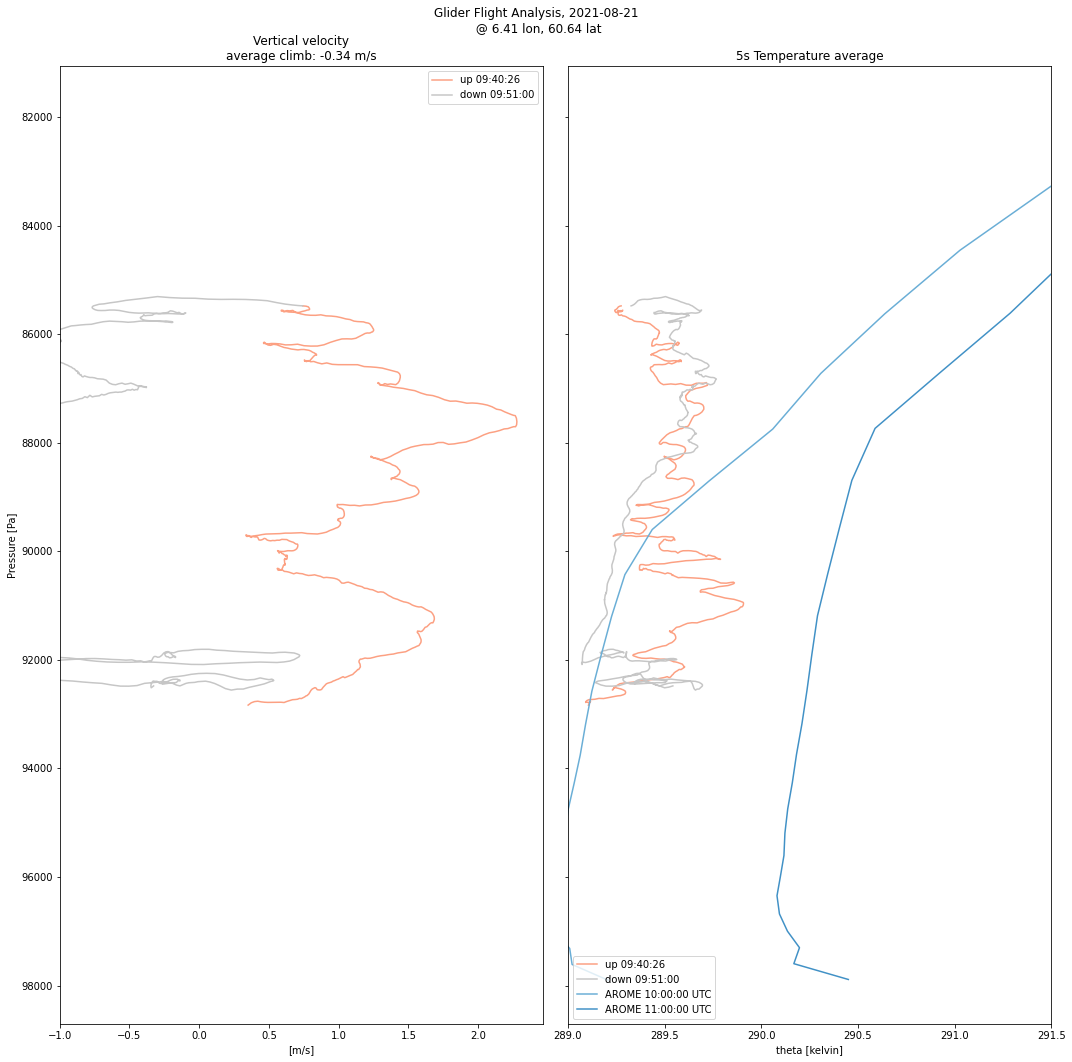

(2, 1)
(2, 1)


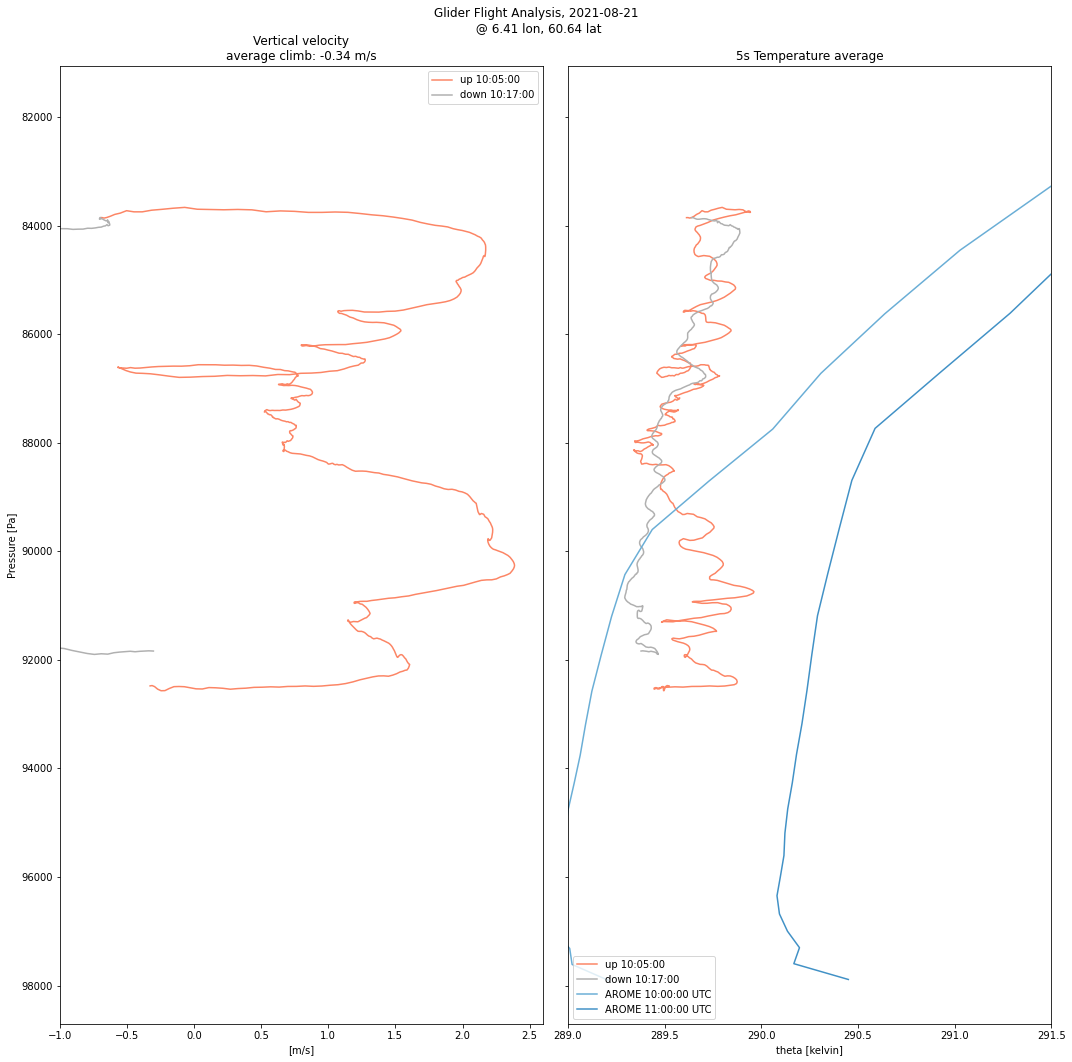

(2, 1)
(2, 1)


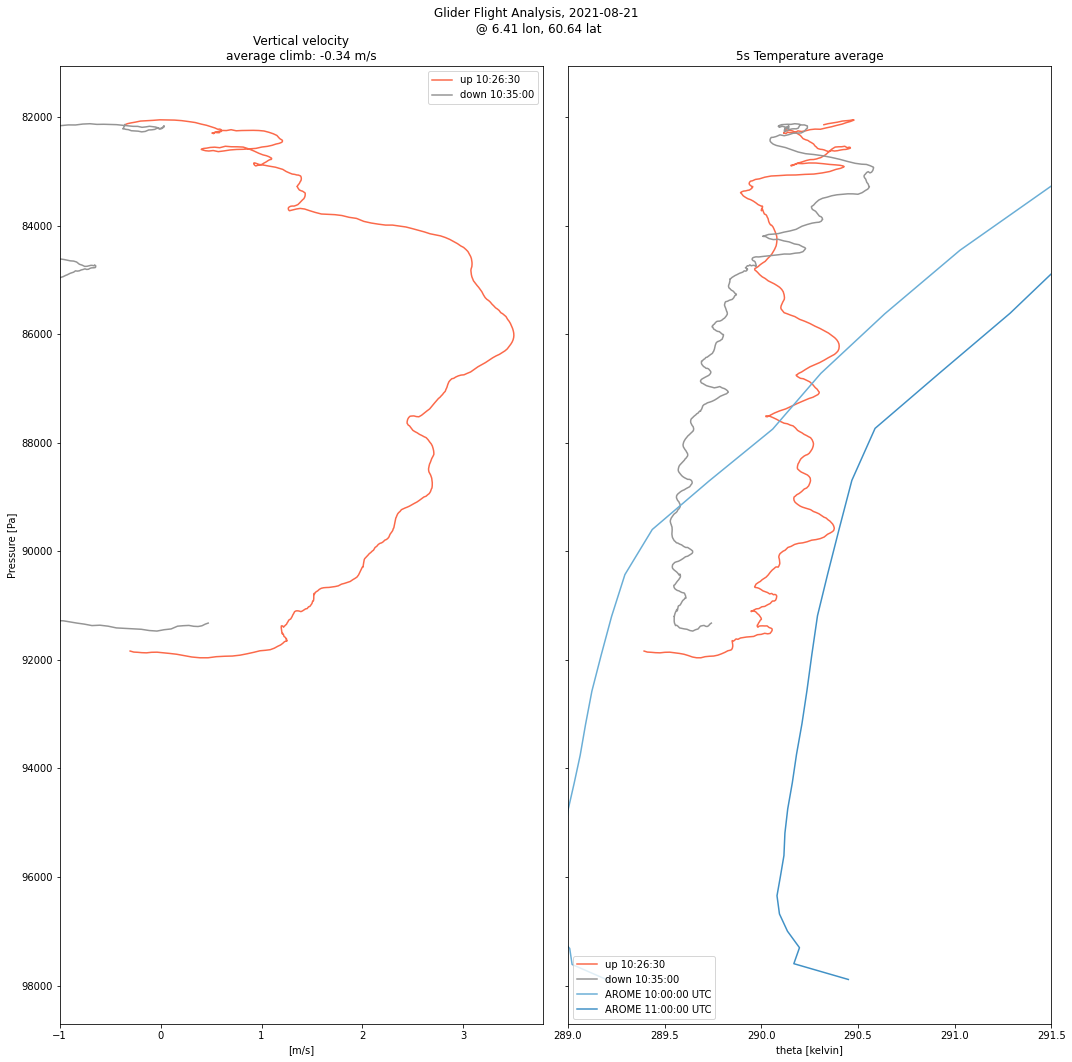

(2, 1)
(2, 1)


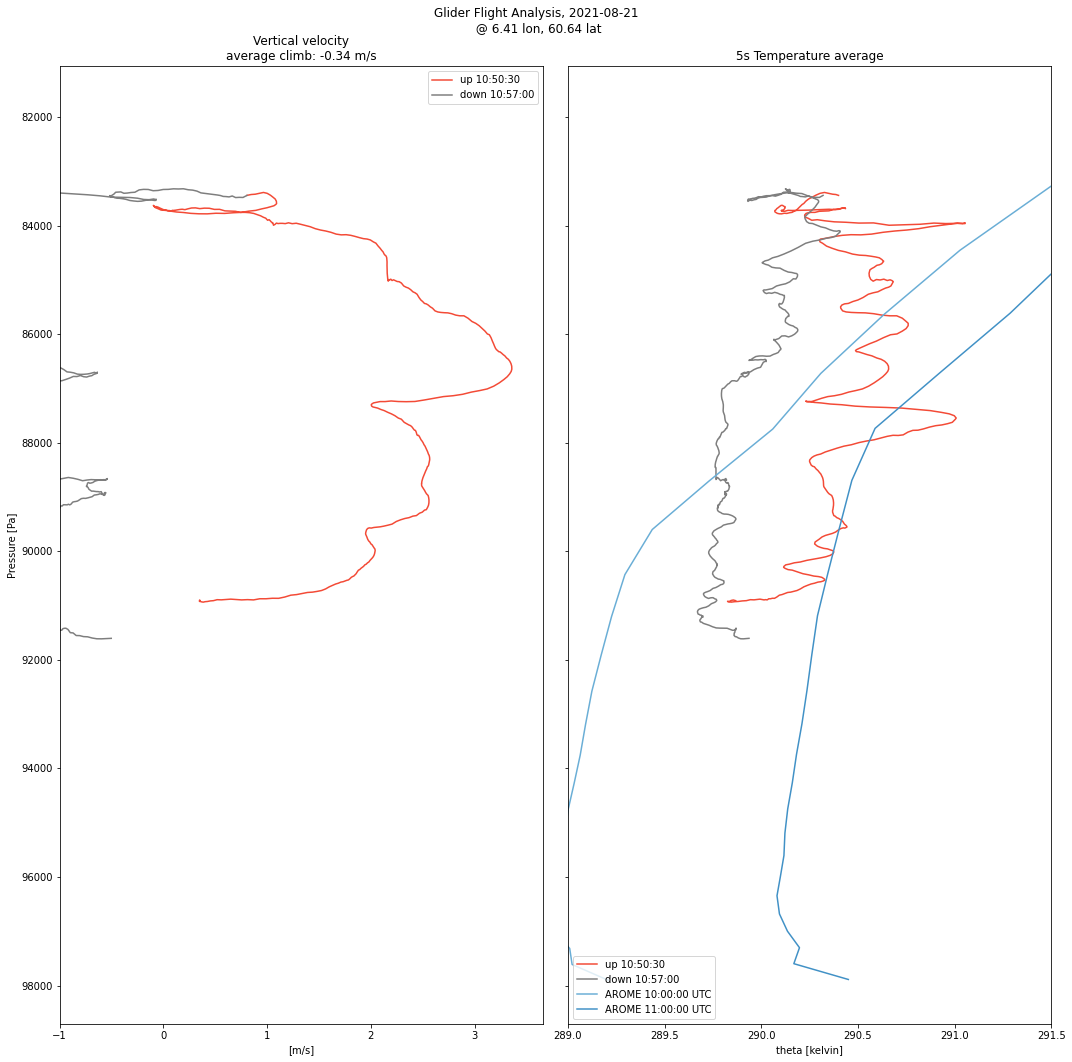

(2, 1)
(2, 1)


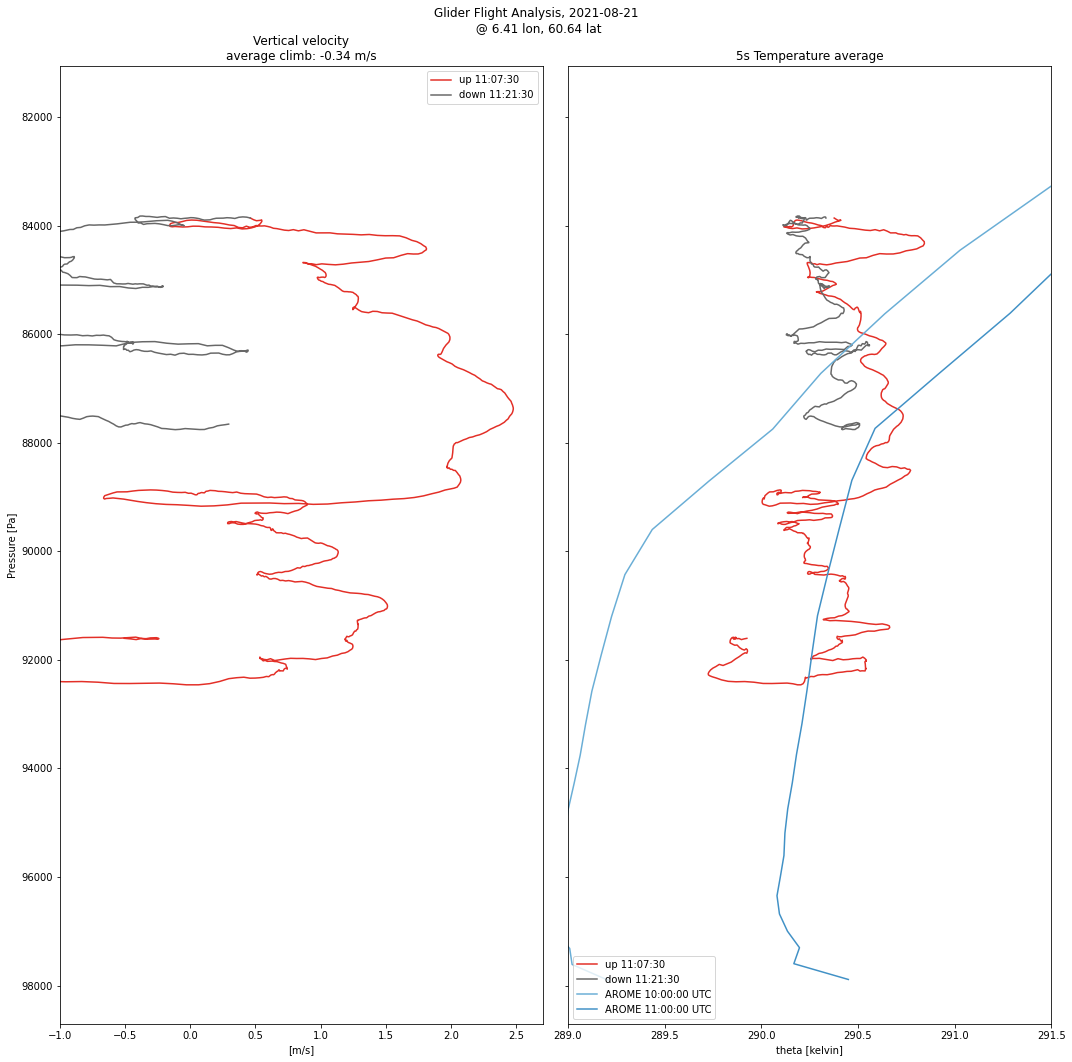

In [98]:

AROME_indices=[
    AROME_index,
#     (AROME_index[0] - 1, AROME_index[1] - 1),
#     (0,0)
]

sigma = 5

i=sel.altitude.argmin()
j=sel.altitude.argmax()

m = sel.iloc[[i,j]]
A = m.altitude.values
T = m.time.values.astype(float) * 1e-9

average_climb = (A[1] - A[0]) / (T[1] - T[0])

# plt.figure(figsize=(10,10),)


for i, thm in enumerate(thermals[:5]):
    
    
    fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,15))

    x_val = (offset+i) / (len(thermals) + offset)
    
    c_up = plt.get_cmap('Reds')(x_val)
    c_down = plt.get_cmap('Greys')(x_val)
    
    up = select(df, thm[0], thm[1])
    dw = select(df, thm[1], thm[2])
    
    ax[0].plot(up.vario, up.pressure, c=c_up,   label='up {}'.format(up.time.iloc[0].time()))
    ax[0].plot(dw.vario, dw.pressure, c=c_down, label='down {}'.format(dw.time.iloc[0].time()))

    ax[1].plot(gaussian_filter1d(up['theta'].values, sigma, mode='nearest'), 
               up.pressure, c=c_up, label='up {}'.format(up.time.iloc[0].time()),)
    ax[1].plot(gaussian_filter1d(dw['theta'].values, sigma, mode='nearest'), 
               dw.pressure, c=c_down, label='down {}'.format(dw.time.iloc[0].time()),)
    
    ax[0].set_xlim(-1)
    ax[0].set_title('Vertical velocity\naverage climb: {:0.2f} m/s'.format(average_climb))
    ax[0].set_xlabel('[m/s]')
    ax[0].legend()


# for l in data.label.unique():
#     dl = data[data.label==l]
#     ax[1].plot(gaussian_filter1d(dl.theta.values, sigma), dl.pressure, '.', label=dl.index[0], c=cmap(LR(dl.index[0])), markersize=2)
    

    time_LR = linear_range(int(meps_6['time'][0]), int(meps['time'][2]))
    blues = plt.get_cmap('Blues')

    for index in AROME_indices:

        for t in [4,5]:

            T, p, theta = get_AROME_at_index(meps_6, index, t)

            plt.plot(theta[40:,0], p[40:,0], c=blues(time_LR(int(meps_6['time'][t]))),
                     label='AROME {} UTC'.format(
                datetime.datetime.fromtimestamp(int(meps_6['time'][t]), tz=datetime.timezone.utc).time(),
    #             lon[index],
    #             lat[index]
            ))

#     for t in [0,1,2]:
    
#         T, p, theta = get_AROME_at_index(meps, index, t)

#         plt.plot(theta[40:,0], p[40:,0], c=blues(time_LR(int(meps['time'][t]))),
#                  label='AROME {} UTC'.format(
#             datetime.datetime.fromtimestamp(int(meps['time'][t]), tz=datetime.timezone.utc).time(),
# #             lon[index],
# #             lat[index]
#         ))

    # ax[1].plot(tow.theta.mean() * np.ones_like(tow.pressure.values), tow.pressure)
    # ax[1].plot(sel.theta.mean() * np.ones_like(sel.pressure.values), sel.pressure)
    ax[1].set_xlabel('theta [kelvin]')
    ax[1].set_xlim(289.0, 291.5)

    plt.gca().invert_yaxis()
    plt.legend(loc=3)
    plt.gcf().patch.set_facecolor('xkcd:white')
    ax[0].set_ylabel('Pressure [Pa]')
    plt.title('{}s Temperature average'.format( sigma ))
    plt.suptitle('Glider Flight Analysis, {}\n @ {:.3} lon, {:.4} lat'.format(sel.time.iloc[0].date(), lon[AROME_index], lat[AROME_index]))
    plt.tight_layout()

    plt.savefig(repr(i) + '-Saturday' + '_' + 'arome' + '.png')

    plt.show()



In [95]:
# lon.shape = lon.size
# lat.shape = lat.size
print(np.stack((lat.flatten(), lon.flatten())).T)

[[60.58795676  6.37478962]
 [60.59096018  6.42011343]
 [60.59394788  6.46544586]
 [60.61021261  6.36865341]
 [60.61321821  6.41400868]
 [60.61620807  6.4593726 ]
 [60.63246856  6.36250851]
 [60.63547634  6.4078953 ]
 [60.63846838  6.45329074]
 [60.65472461  6.35635491]
 [60.65773457  6.40177325]
 [60.66072878  6.44720027]
 [60.67698076  6.35019259]
 [60.6799929   6.39564253]
 [60.68298928  6.44110116]]


# Export data for IsoTrotter

In [102]:
copy = data.copy()
copy.pressure = 0.01 * copy.pressure # save as hPa

In [103]:
save_file_name = '../data/iMet/export/iMet-{}.csv'.format(copy.index[0].date())

In [104]:
copy.to_csv(save_file_name)
d = pd.read_csv(save_file_name, parse_dates=['time'])

In [105]:
d

time               time.1     id          dd  \
0     2021-08-21 09:40:26  2021-08-21 09:40:26  44507  2021/08/21   
1     2021-08-21 09:40:27  2021-08-21 09:40:27  44507  2021/08/21   
2     2021-08-21 09:40:28  2021-08-21 09:40:28  44507  2021/08/21   
3     2021-08-21 09:40:29  2021-08-21 09:40:29  44507  2021/08/21   
4     2021-08-21 09:40:30  2021-08-21 09:40:30  44507  2021/08/21   
...                   ...                  ...    ...         ...   
11437 2021-08-21 14:29:56  2021-08-21 14:29:56  44507  2021/08/21   
11438 2021-08-21 14:29:57  2021-08-21 14:29:57  44507  2021/08/21   
11439 2021-08-21 14:29:58  2021-08-21 14:29:58  44507  2021/08/21   
11440 2021-08-21 14:29:59  2021-08-21 14:29:59  44507  2021/08/21   
11441 2021-08-21 14:30:00  2021-08-21 14:30:00  44507  2021/08/21   

                    tt code  pressure  temperature    RH  RH_temp  ...  \
0      21:43:51.552947   XQ    928.34         9.82  67.1    10.97  ...   
1      21:43:51.578950   XQ    927.91         9.99  67.8    11.01  ...   
2      21:43:51.604991   XQ    927.69        10.03  68.1    11.04  ...   
3      21:43:51.631253   XQ    927.62         9.91  68.3    11.04  ...   
4      21:43:51.656963   XQ    927.74         9.87  68.5    11.05  ...   
...                ...  ...       ...          ...   ...      ...  ...   
11437  21:51:22.214934   XQ    960.88        15.55  43.7    16.35  ...   
11438  21:51:22.240877   XQ    961.11        15.58  43.6    16.35  ...   
11439  21:51:22.266796   XQ    961.23        15.59  43.3    16.35  ...   
11440  21:51:22.292732   XQ    961.29        15.63  43.3    16.37  ...   
11441  21:51:22.318684   XQ    961.30        15.70  43.4    16.39  ...   

       theta_virtual  equivalent_potential_temperature     vario   dt  \
0         290.010947                        304.900823  0.351078  1.0   
1         290.245334                        305.471530  0.373462  1.0   
2         290.313268                        305.651405  0.396642  1.0   
3         290.191437                        305.447555  0.420382  1.0   
4         290.139782                        305.394063  0.444459  1.0   
...              ...                               ...       ...  ...   
11437     292.908811                        306.780571 -0.595319  1.0   
11438     292.918703                        306.783031 -0.560949  1.0   
11439     292.912720                        306.692302 -0.525884  1.0   
11440     292.950338                        306.765173 -0.490238  1.0   
11441     293.026610                        306.935909 -0.454189  1.0   

                   x             y        vx        vy     speed     labels  
0      358286.323453  6.725777e+06 -2.582017 -4.803816  5.453757  817301758  
1      358283.741436  6.725773e+06 -2.511804 -3.301434  4.148328  817301758  
2      358281.229633  6.725769e+06 -2.924316 -4.043308  4.989986  817301758  
3      358278.305316  6.725765e+06 -2.789215 -5.475742  6.145199  817301758  
4      358275.516101  6.725760e+06 -2.403205 -6.237970  6.684883  817301758  
...              ...           ...       ...       ...       ...        ...  
11437  360197.014465  6.721105e+06 -3.209891  7.538703  8.193622  817301765  
11438  360193.804574  6.721112e+06 -2.913433  7.973143  8.488763  817301765  
11439  360190.891141  6.721120e+06 -2.970048  7.362158  7.938675  817301765  
11440  360187.921093  6.721127e+06 -2.830355  6.442527  7.036836  817301765  
11441  360185.090738  6.721134e+06 -2.904975  5.932581  6.605634  817301765  

[11442 rows x 28 columns]

In [127]:
d.time.values.astype(float)

array([1.62953883e+18, 1.62953883e+18, 1.62953883e+18, ...,
       1.62955620e+18, 1.62955620e+18, 1.62955620e+18])